# COVID-19 Data Analyses using Johns Hopkins Data

Note: The most up-to-date version of this notebook can be found in GitHub repository [bmc/covid19][].

The primary data source for this notebook is the Johns Hopkins University's Center for Systems Science and Engineering (CSSE) 
[COVID-19 data repository](https://github.com/CSSEGISandData/COVID-19).

For additional data sources used, see [the README](https://github.com/bmc/covid19/blob/master/README.md)
in [bmc/covid19].

## Approach

This notebook loads the Johns Hopkins COVID-19 CSV files into a [Pandas](https://pandas.pydata.org/) DataFrame. It
then manipulates, queries, and plots the DataFrame.

[**I don't want to look at code. Take me to the first graph!**](#United-States)

[bmc/covid19]: https://github.com/bmc/covid19/

## Imports and constants

In [1]:
import matplotlib
import matplotlib.pyplot as p
import numpy as np
import pandas as pd
from datetime import datetime, timedelta, date, timezone
import csv
import os
import sys
import re
import math
from glob import glob
from pprint import pprint
from enum import Enum
from itertools import chain
from lib.common import *
from lib.plot import *

print(f"Using Python {sys.version_info.major}.{sys.version_info.minor}.{sys.version_info.micro}")
print(f"Using matplotlib {matplotlib.__version__}")
print(f"Using Pandas {pd.__version__}")
now = datetime.now(timezone.utc)
print(f"Last run on {now.strftime('%Y-%m-%d')} at {now.strftime('%H:%M:%S %Z')}")

Using Python 3.8.6
Using matplotlib 3.3.2
Using Pandas 1.1.4
Last run on 2020-11-20 at 16:10:04 UTC


In [2]:
JOHNS_HOPKINS_US_DIR_PATH = 'data/johns-hopkins/COVID-19/csse_covid_19_data/csse_covid_19_daily_reports_us'
# The detailed path contains other countries and has data down to the US county level.
JOHNS_HOPKINS_DETAILED_DIR_PATH = 'data/johns-hopkins/COVID-19/csse_covid_19_data/csse_covid_19_daily_reports'
SOURCE = "Johns Hopkins University Center for Systems Science and Engineering (CSSE)"

In [3]:
os.makedirs(IMAGES_PATH, exist_ok=True)
today = datetime.now().date()

In [4]:
for p in glob(os.path.join(IMAGES_PATH, 'jhu*')):
    os.unlink(p)

## Helpers

In [5]:
def read_raw_data(dir: str) -> pd.DataFrame:
    """
    Read the raw data, consisting of a number of CSV files
    with timestamped names, into a single Pandas DataFrame.
    Does not translate the columns or clean anything up.
    """
    f_pat = re.compile(r'^([01]\d-[0123]\d-202\d)\.csv')
    data_frames = []
    for f in os.listdir(dir):
        # Skip any file that doesn't match the regex. It'd
        # probably be sufficient to check the extension, but
        # this approach is more robust.
        m = f_pat.match(f)
        if m is None:
            continue
        df = pd.read_csv(os.path.join(dir, f))
        file_date = datetime.strptime(m.group(1), '%m-%d-%Y')
        if file_date < STARTING_DATE:
            continue

        df['Date'] = file_date
        # Now, convert to Pandas datetime. You can't store a regular
        # Python date or datetime in Pandas and then operate on it
        # using Pandas datetime functions. It has to be a Pandas
        # datetime.
        df['Date'] = pd.to_datetime(df['Date'])
        data_frames.append(df)

    return pd.concat(data_frames, ignore_index=True)

def read_top_level_us_data() -> pd.DataFrame:
    """
    Read all CSV files into a single Pandas DataFrame, normalizing
    the column names and discarding the ones we don't want.
    
    The DataFrame will be sorted by date.
    """
    df = read_raw_data(JOHNS_HOPKINS_US_DIR_PATH)[[
        'Date', 'Province_State', 'Confirmed', 'Deaths', 'Recovered',
        'People_Tested', 'People_Hospitalized'
    ]]

    final_df = df.rename(columns={
        'Province_State':      COL_REGION,
        'Date':                COL_DATE,
        'Deaths':              COL_DEATHS,
        'People_Tested':       COL_TESTS,
        'Confirmed':           COL_CASES,
        'Recovered':           COL_RECOVERIES,
        'People_Hospitalized': COL_HOSPITALIZATIONS
    })

    for col in (COL_DEATHS, COL_CASES, COL_TESTS, COL_RECOVERIES, COL_HOSPITALIZATIONS):
        final_df[col] = final_df[col].fillna(0)

    final_df = final_df.astype({
        COL_DEATHS: int,
        COL_CASES: int,
        COL_HOSPITALIZATIONS: int,
        COL_RECOVERIES: int,
        COL_TESTS: int
    })

    make_month_day_column(final_df)

    final_df.sort_values(by=[COL_DATE], inplace=True)
    return final_df

In [6]:
def read_us_county_data() -> pd.DataFrame:
    """
    Reads the Johns Hopkins COVID-19 data that contains
    more detailed data, down to the county. Then, weed
    out non-US data and normalize the rest somewhat.
    """
    df = read_raw_data(JOHNS_HOPKINS_DETAILED_DIR_PATH)
    df2 = df.loc[df['Country_Region'] == 'US'][[
        'Date', 'Admin2', 'Province_State', 'Confirmed',
        'Deaths', 'Recovered'
    ]]

    final_df = df2.rename(columns={
        'Date':           COL_DATE,
        'Admin2':         COL_COUNTY,
        'Province_State': COL_REGION,
        'Confirmed':      COL_CASES,
        'Deaths':         COL_DEATHS,
        'Recovered':      COL_RECOVERIES,
    })

    for col in (COL_DEATHS, COL_CASES, COL_RECOVERIES):
        final_df[col] = final_df[col].fillna(0)

    make_month_day_column(final_df)
    final_df.sort_values(by=[COL_DATE], inplace=True)
    return final_df

## Read the data

### Load the state population data

In [7]:
populations = load_united_states_population_data()
print(f"{populations['United States']:,}")

334,351,340


### Load the Johns Hopkins data

In [8]:
%ls $JOHNS_HOPKINS_US_DIR_PATH

04-12-2020.csv  05-27-2020.csv  07-11-2020.csv  08-25-2020.csv  10-09-2020.csv
04-13-2020.csv  05-28-2020.csv  07-12-2020.csv  08-26-2020.csv  10-10-2020.csv
04-14-2020.csv  05-29-2020.csv  07-13-2020.csv  08-27-2020.csv  10-11-2020.csv
04-15-2020.csv  05-30-2020.csv  07-14-2020.csv  08-28-2020.csv  10-12-2020.csv
04-16-2020.csv  05-31-2020.csv  07-15-2020.csv  08-29-2020.csv  10-13-2020.csv
04-17-2020.csv  06-01-2020.csv  07-16-2020.csv  08-30-2020.csv  10-14-2020.csv
04-18-2020.csv  06-02-2020.csv  07-17-2020.csv  08-31-2020.csv  10-15-2020.csv
04-19-2020.csv  06-03-2020.csv  07-18-2020.csv  09-01-2020.csv  10-16-2020.csv
04-20-2020.csv  06-04-2020.csv  07-19-2020.csv  09-02-2020.csv  10-17-2020.csv
04-21-2020.csv  06-05-2020.csv  07-20-2020.csv  09-03-2020.csv  10-18-2020.csv
04-22-2020.csv  06-06-2020.csv  07-21-2020.csv  09-04-2020.csv  10-19-2020.csv
04-23-2020.csv  06-07-2020.csv  07-22-2020.csv  09-05-2020.csv  10-20-2020.csv
04-24-2020.csv  06-08-2020.csv  07-23-2020.csv  09-0

In [9]:
%head $JOHNS_HOPKINS_US_DIR_PATH/04-12-2020.csv

Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,FIPS,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,UID,ISO3,Testing_Rate,Hospitalization_Rate
Alabama,US,2020-04-12 23:18:15,32.3182,-86.9023,3667,93,,3470,1,75.98802021,21583,437,2.610159978,84000001,USA,460.3001516,12.26494527
Alaska,US,2020-04-12 23:18:15,61.3707,-152.4044,272,8,66,264,2,45.50404936,8038,31,2.941176471,84000002,USA,1344.711576,11.39705882
Arizona,US,2020-04-12 23:18:15,33.7298,-111.4312,3542,115,,3427,4,48.66242224,42109,,3.246753247,84000004,USA,578.5222863,
Arkansas,US,2020-04-12 23:18:15,34.9697,-92.3731,1280,27,367,1253,5,49.43942261,19722,130,2.109375,84000005,USA,761.7533537,10.15625
California,US,2020-04-12 23:18:15,36.1162,-119.6816,22795,640,,22155,6,58.13772584,190328,5234,2.81202018,84000006,USA,485.4238685,22.9611757
Colorado,US,2020-04-12 23:18:15,39.0598,-105.3111,7307,289,,7018,8,128.943729,34873,1376,3.955111537,84000008,USA,615.3899908,18.8312577
C

In [10]:
df = read_top_level_us_data()

In [11]:
df

date         region   cases  deaths  recoveries   tests  \
0     2020-04-12        Alabama    3667      93           0   21583   
32    2020-04-12  New Hampshire     929      23         236   10925   
33    2020-04-12     New Jersey   61850    2350           0  126735   
34    2020-04-12     New Mexico    1245      26         235   28692   
35    2020-04-12       New York  189033    9385       23887  461601   
...          ...            ...     ...     ...         ...     ...   
12859 2020-11-19          Maine    9734     171        7403       0   
12860 2020-11-19       Maryland  174733    4372        8441       0   
12861 2020-11-19  Massachusetts  198550   10435      145682       0   
12848 2020-11-19        Georgia  437156    9102           0       0   
12893 2020-11-19        Wyoming   26169     176       14904       0   

       hospitalizations month_day  
0                   437     04/12  
32                  146     04/12  
33                 7604     04/12  
34                   78     04/12  
35                42594     04/12  
...                 ...       ...  
12859                 0     11/19  
12860                 0     11/19  
12861                 0     11/19  
12848                 0     11/19  
12893                 0     11/19  

[12894 rows x 8 columns]

In [12]:
jhu_starting_date = df.date.min().date()
jhu_ending_date = df.date.max().date()
# See https://stackoverflow.com/a/15411596
total_unique_dates = len(df.groupby('date').date.nunique())
print(f"Loaded data for {total_unique_dates} days.")
# len(dataframe.index) is the idiom for getting the number of rows.
print(f"Total rows: {len(df.index):,}")
print(f"Starting date: {datestr(jhu_starting_date, include_year=True)}")
print(f"Ending date: {datestr(jhu_ending_date, include_year=True)}")

Loaded data for 222 days.
Total rows: 12,894
Starting date: 04/12/2020
Ending date: 11/19/2020


In [13]:
df_counties = read_us_county_data()

In [14]:
df_counties

date     county          region  cases  deaths  recoveries  \
0      2020-04-12  Abbeville  South Carolina      9     0.0         0.0   
1812   2020-04-12    Ontario        New York     57     0.0         0.0   
1813   2020-04-12  Ontonagon        Michigan      0     0.0         0.0   
1814   2020-04-12     Orange      California   1277    19.0         0.0   
1815   2020-04-12     Orange         Florida    949    13.0         0.0   
...           ...        ...             ...    ...     ...         ...   
830066 2020-11-19  McCracken        Kentucky   2096    14.0         0.0   
830067 2020-11-19   McCreary        Kentucky    329     1.0         0.0   
830068 2020-11-19     McLean        Kentucky    334    12.0         0.0   
830058 2020-11-19      Logan        Kentucky   1043    33.0         0.0   
832245 2020-11-19     Weston         Wyoming    355     0.0         0.0   

       month_day  
0          04/12  
1812       04/12  
1813       04/12  
1814       04/12  
1815       04/12  
...          ...  
830066     11/19  
830067     11/19  
830068     11/19  
830058     11/19  
832245     11/19  

[700021 rows x 7 columns]

In [15]:
print(f"COUNTY DATA:")
print(f"Read data for {len(df_counties[COL_DATE].unique())} days.")
print(f"Starting date: {datestr(df_counties[COL_DATE].min(), include_year=True)}")
print(f"Ending date: {datestr(df_counties[COL_DATE].max(), include_year=True)}")

COUNTY DATA:
Read data for 222 days.
Starting date: 04/12/2020
Ending date: 11/19/2020


## Deaths and cases in a single region

### United States

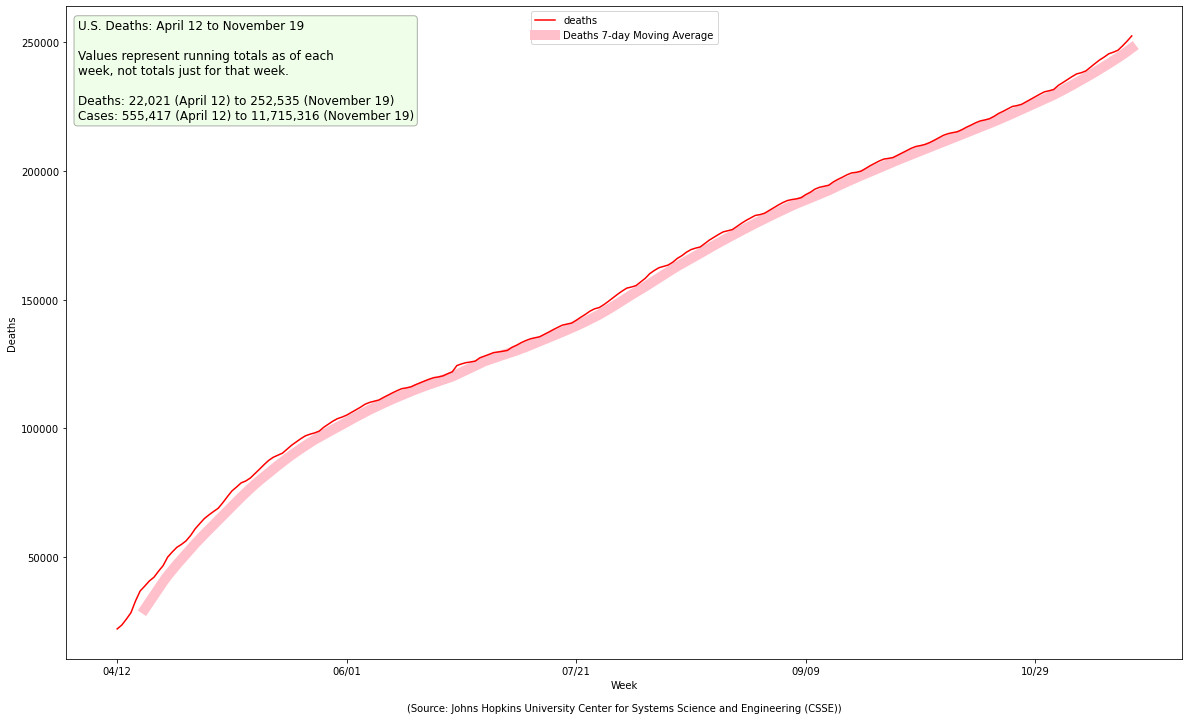

In [16]:
plot_stats_by_date(df, SOURCE, metrics={MetricType.DEATHS}, moving_average=True,
                   image_file='jhu-us-deaths.png', textbox_heading="U.S. Deaths");

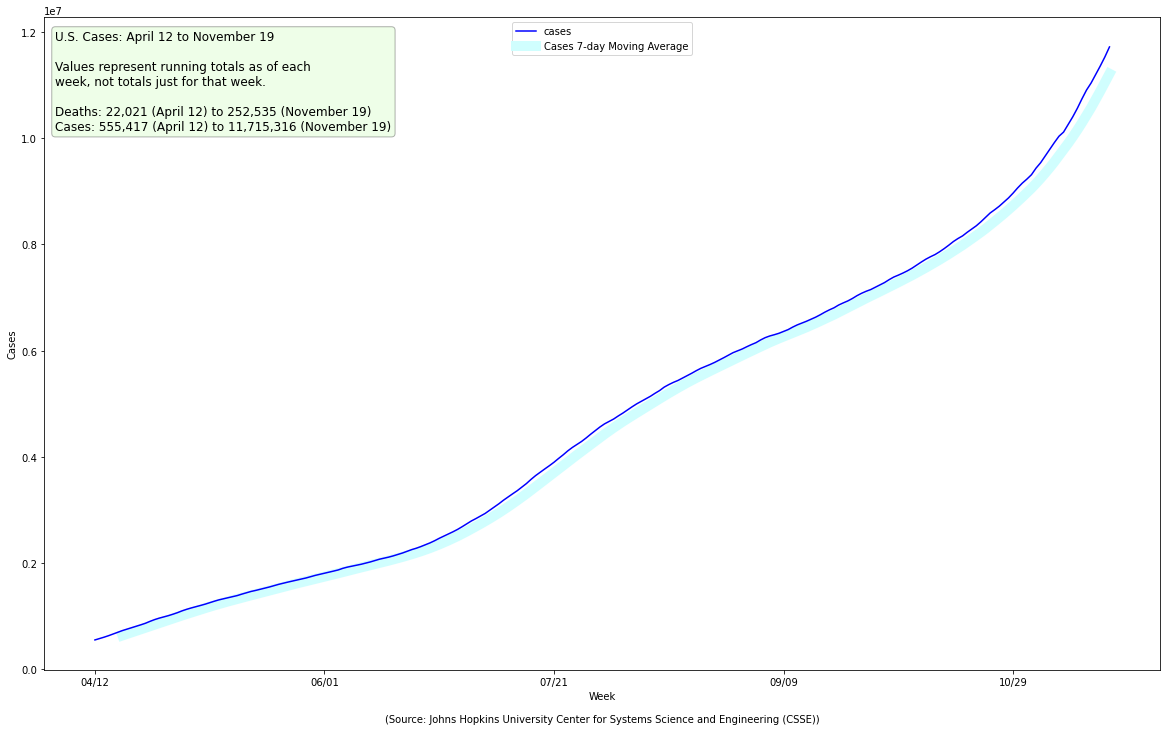

In [17]:
plot_stats_by_date(df, SOURCE, metrics={MetricType.CASES}, moving_average=True,
                   image_file='jhu-us-cases.png', textbox_heading="U.S. Cases");

#### Daily values, instead of cumulative values

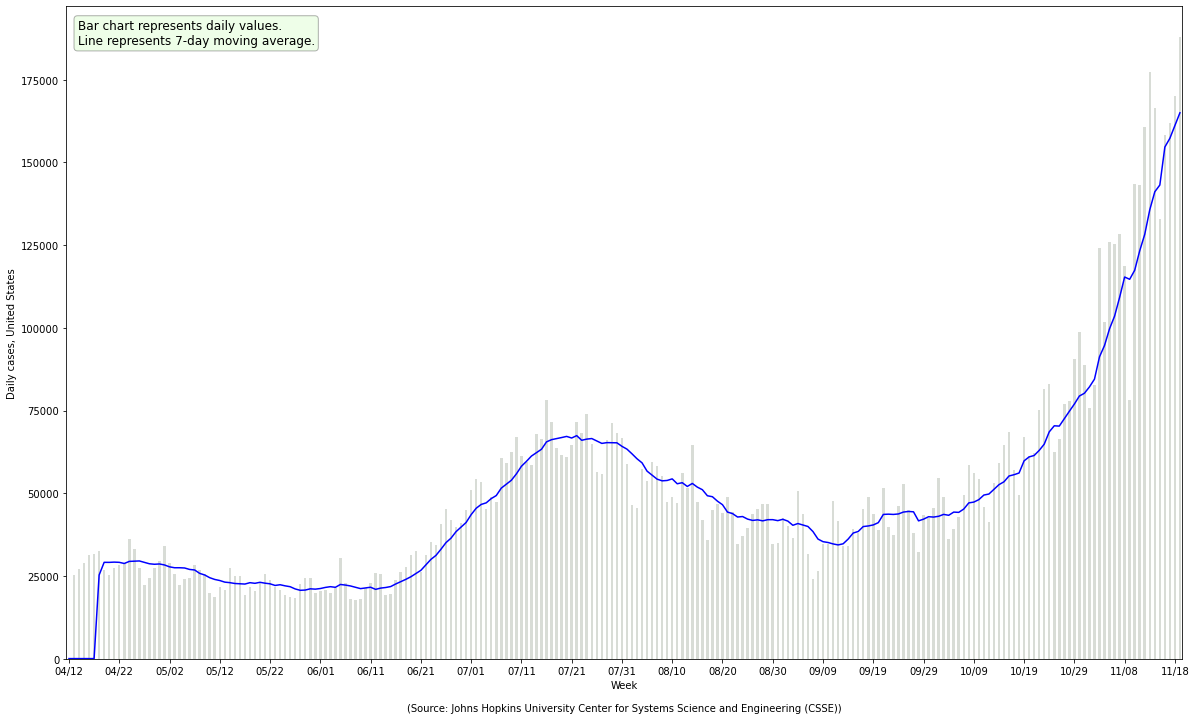

In [18]:
fig, ax, df_with_diffs = plot_daily_stats(df, 
                                          source=SOURCE,
                                          metric=MetricType.CASES,
                                          region='United States',
                                          moving_average=True,
                                          image_file="jhu-us-cases-daily.png");

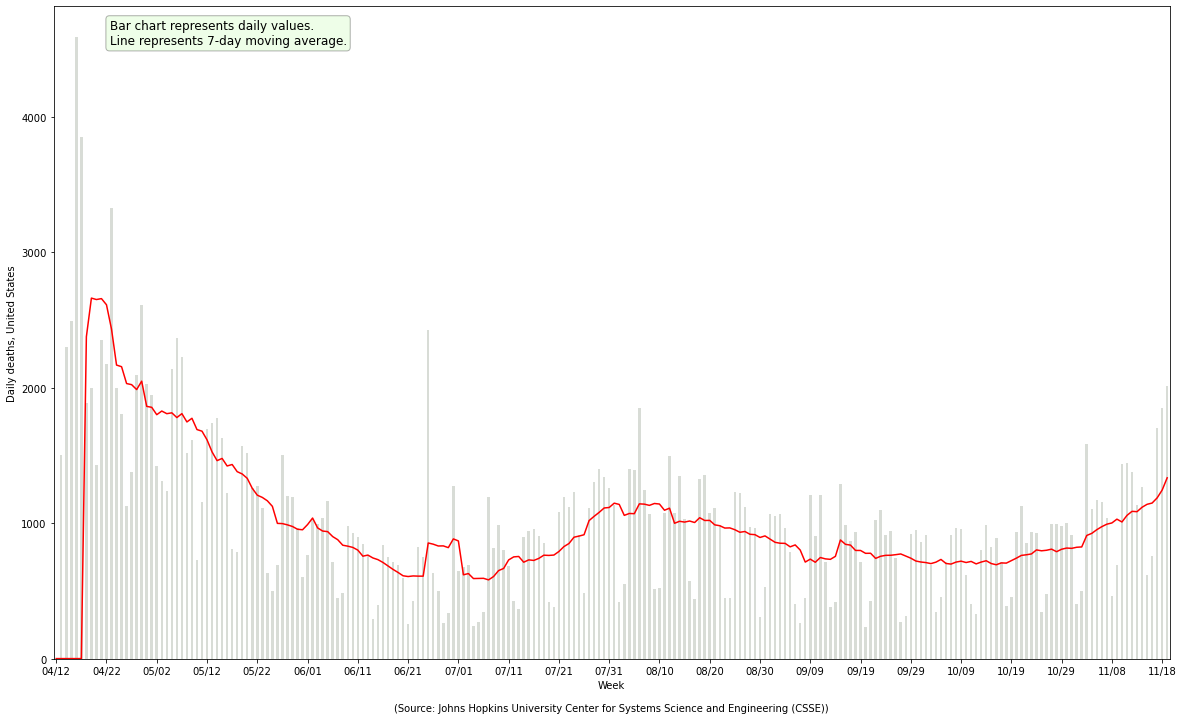

In [19]:
fig, ax, df_with_diffs = plot_daily_stats(df, 
                                          source=SOURCE,
                                          metric=MetricType.DEATHS,
                                          region='United States',
                                          moving_average=True,
                                          image_file="jhu-us-deaths-daily.png",
                                          textbox_loc=(0.05, 0.98))

In [20]:
max_date = df_with_diffs.date.max()
df_with_diffs.loc[df_with_diffs.date == max_date]

date     cases  deaths  recoveries  tests  hospitalizations  \
221 2020-11-19  11715316  252535     4410709      0                 0   

            region month_day    diff      diff_ma  
221  United States     11/19  2015.0  1335.428571

#### Just the past week

In [21]:
week_delta = timedelta(days=6)
six_days_prior = jhu_ending_date - week_delta
last_week_start = date_to_datetime(six_days_prior)
last_week_end = date_to_datetime(jhu_ending_date, hour=23, minute=59, second=59)

df_past_week = df.loc[(df[COL_DATE] >= last_week_start) & (df[COL_DATE] <= last_week_end)]

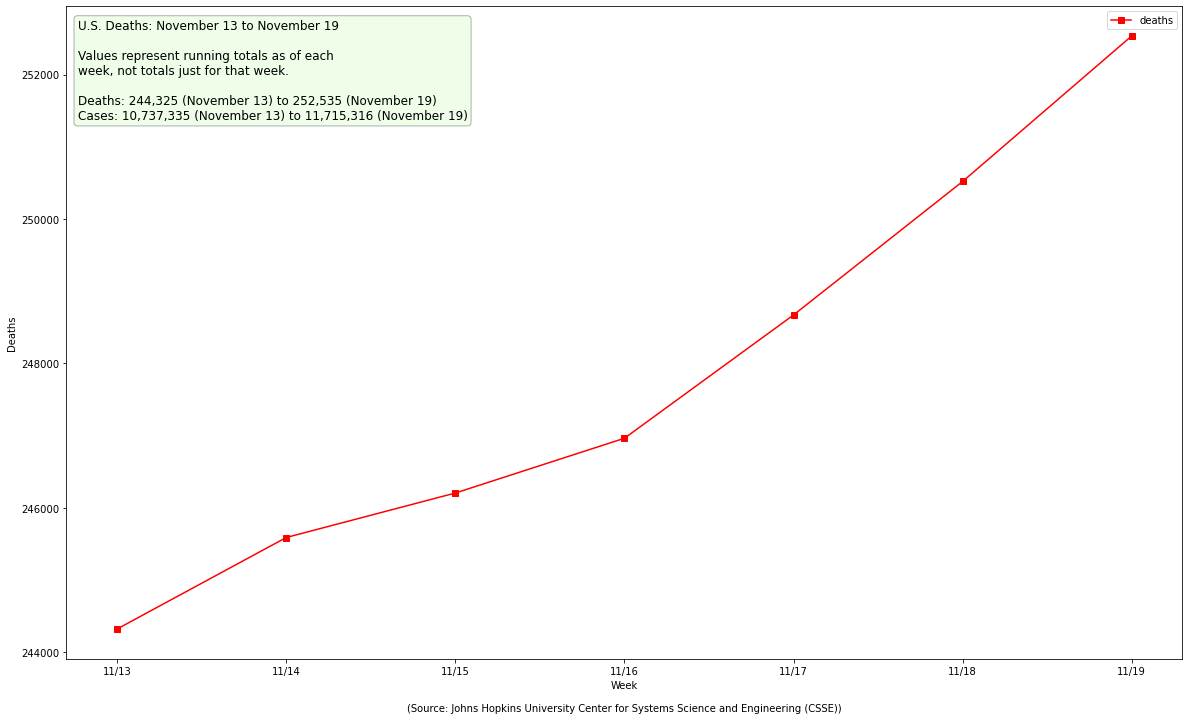

In [22]:
plot_stats_by_date(df_past_week, SOURCE, metrics={MetricType.DEATHS}, marker='s', 
                   textbox_heading="U.S. Deaths", image_file='jhu-us-deaths-past-week.png');

#### Deaths vs. Cases

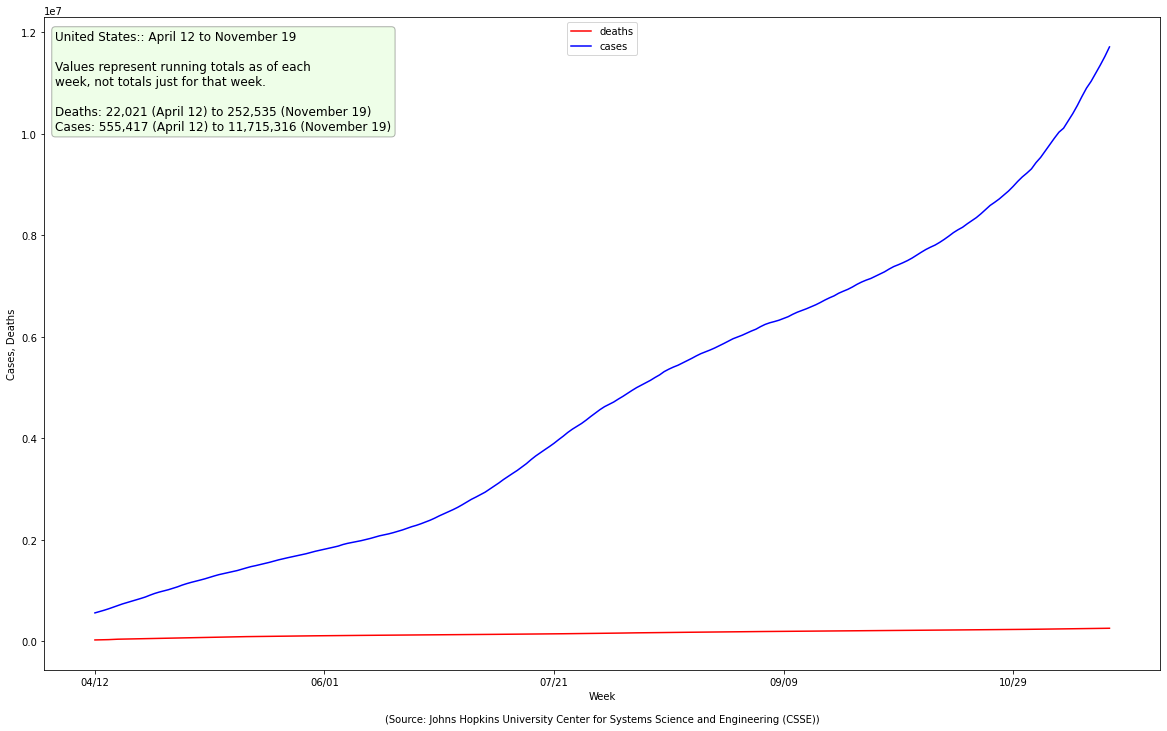

In [23]:
plot_stats_by_date(df, SOURCE, metrics={MetricType.DEATHS, MetricType.CASES}, 
                   textbox_heading="United States:", image_file="jhu-us-deaths-and-cases.png");

### Individual States

#### Pennsylvania

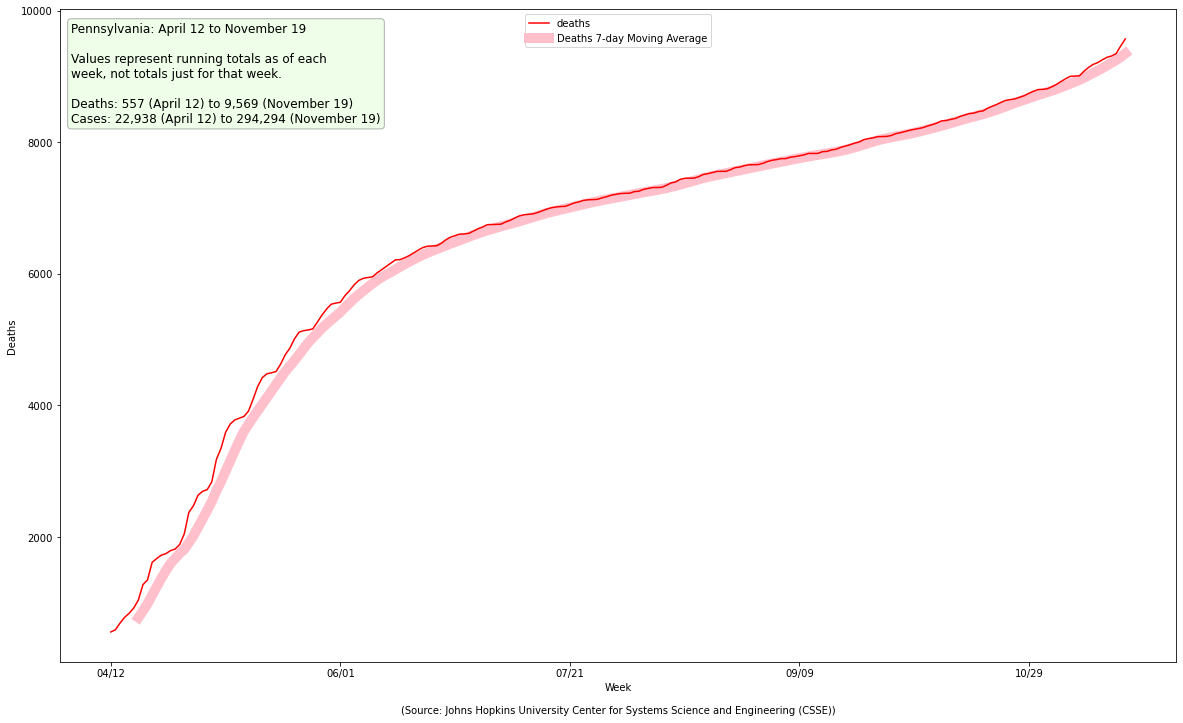

In [24]:
plot_state(df, SOURCE, 'Pennsylvania', image_file='jhu-pa-deaths.png', metrics={MetricType.DEATHS}, moving_average=True);

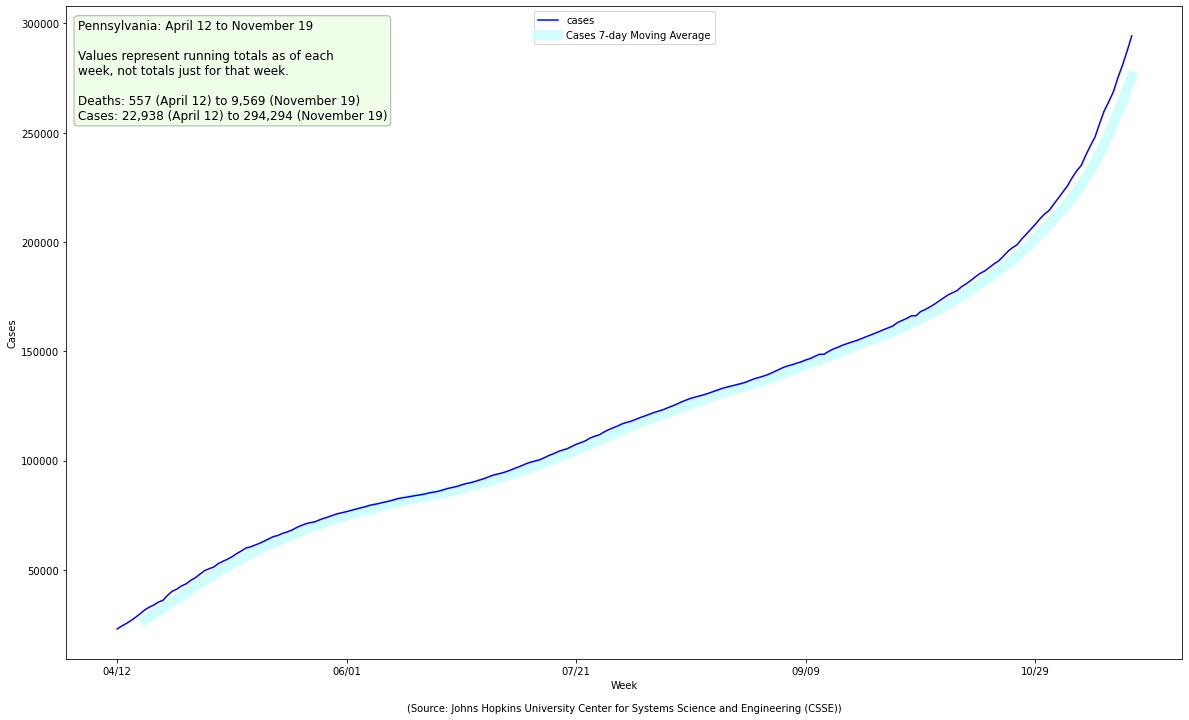

In [25]:
plot_state(df, SOURCE, 'Pennsylvania', image_file='jhu-pa-cases.png', metrics={MetricType.CASES}, moving_average=True);

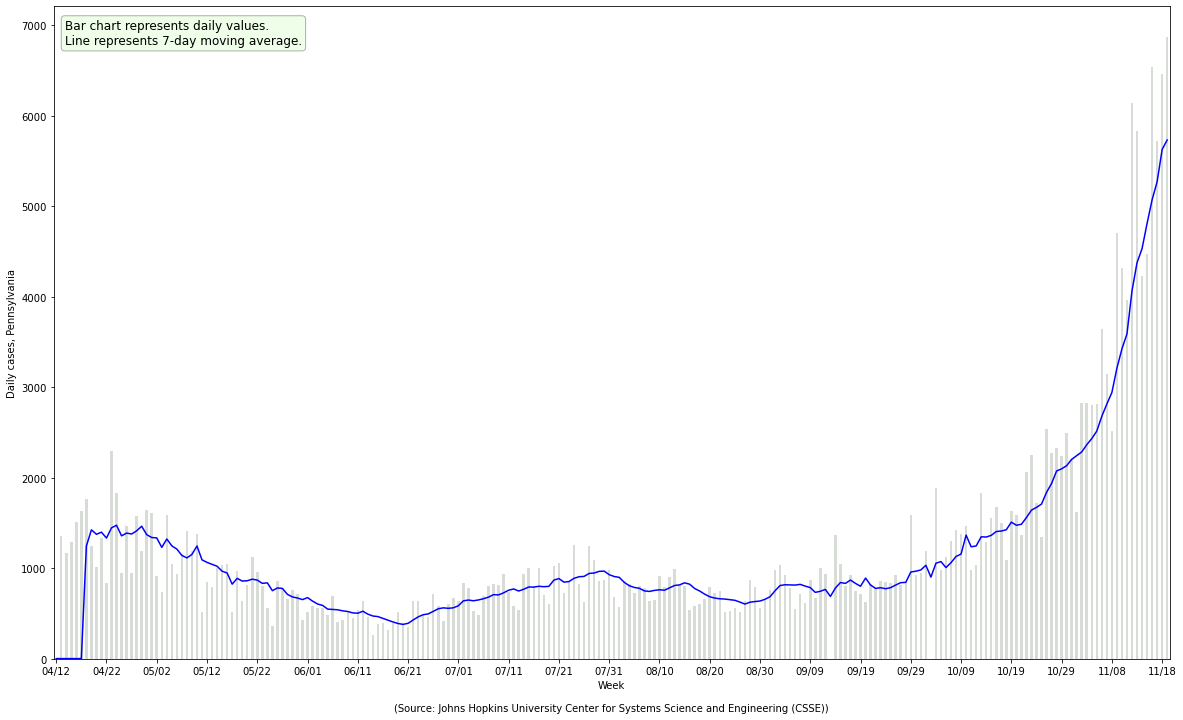

In [26]:
plot_daily_stats(df, 
                 source=SOURCE,
                 metric=MetricType.CASES,
                 region='Pennsylvania',
                 moving_average=True,
                 image_file="jhu-pa-cases-daily.png");

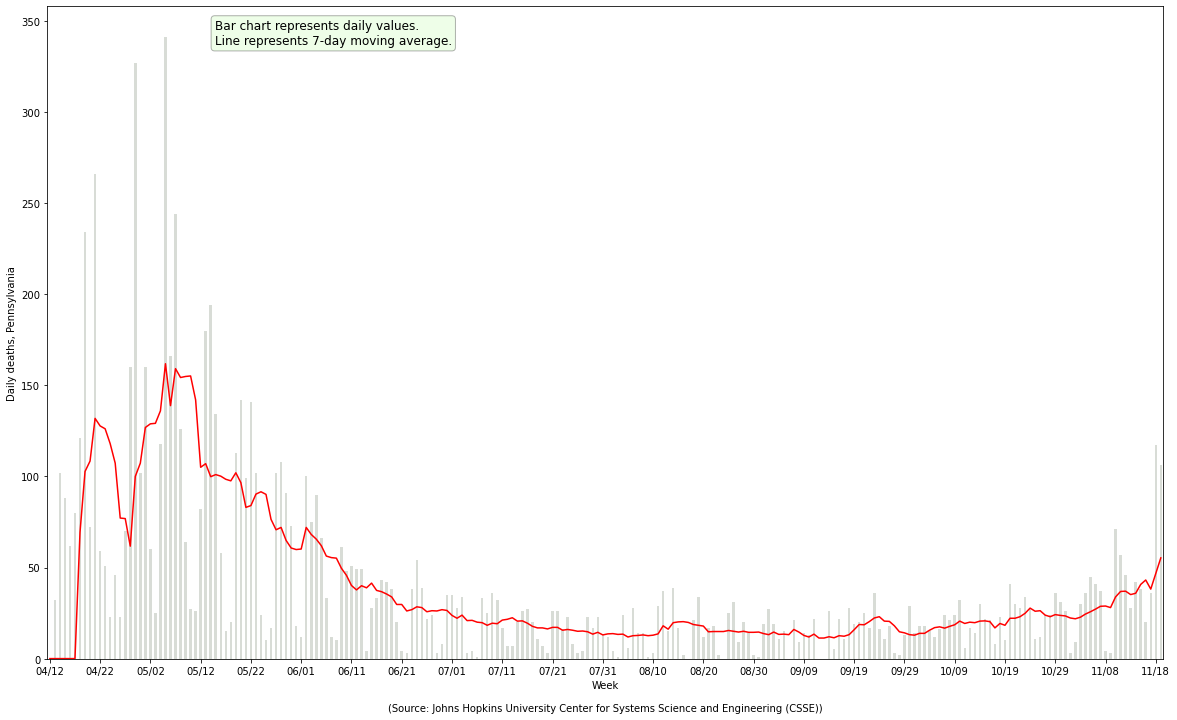

In [27]:
plot_daily_stats(df, 
                 source=SOURCE,
                 metric=MetricType.DEATHS,
                 region='Pennsylvania',
                 moving_average=True,
                 image_file="jhu-pa-deaths-daily.png",
                 textbox_loc=(0.15, 0.98));

#### New Jersey

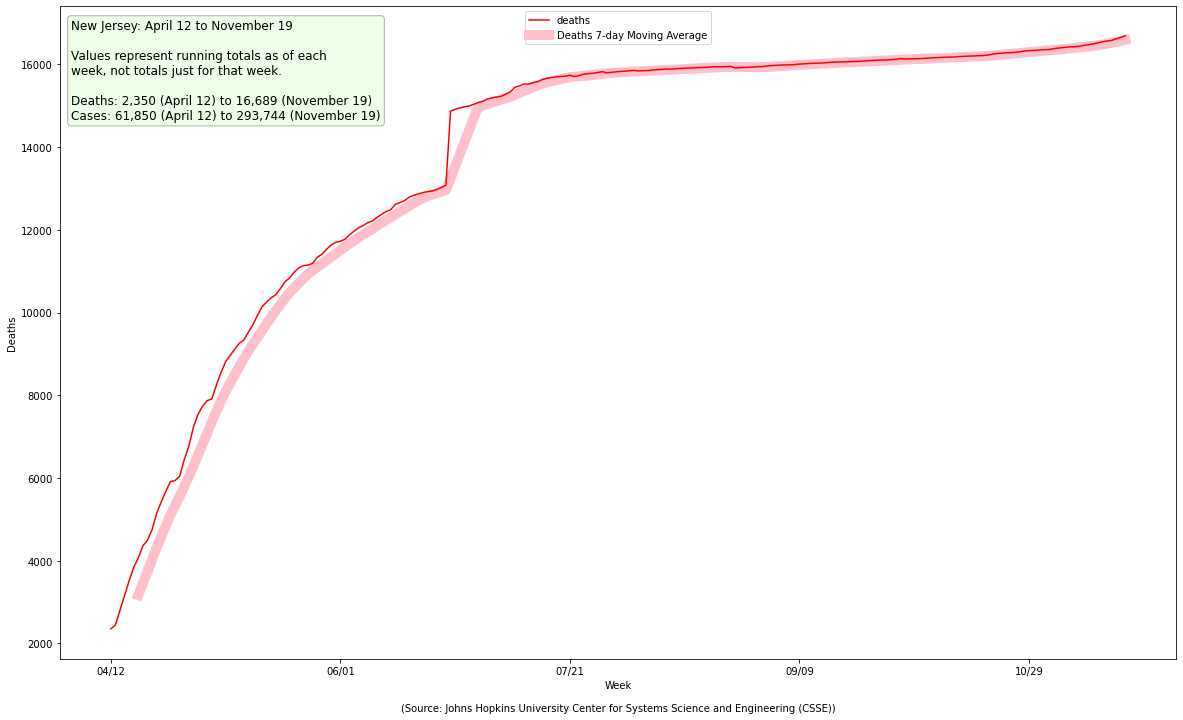

In [28]:
plot_state(df, SOURCE, 'New Jersey', image_file='jhu-nj-deaths.png', metrics={MetricType.DEATHS}, moving_average=True);

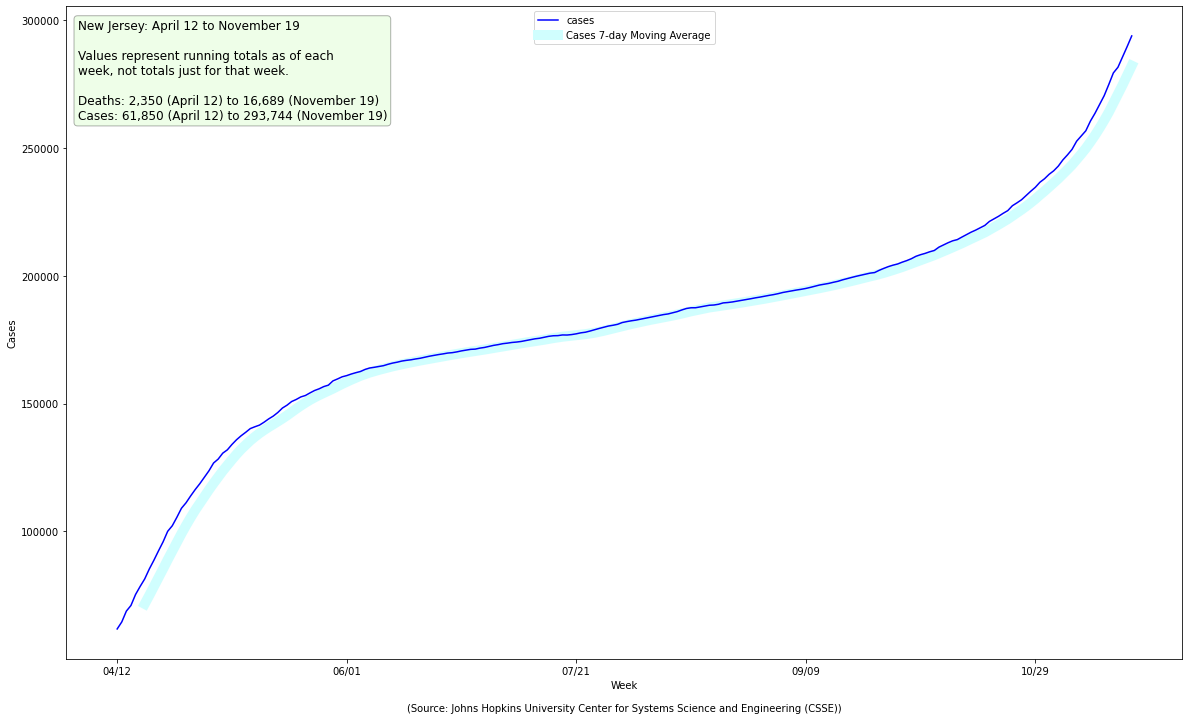

In [29]:
plot_state(df, SOURCE, 'New Jersey', image_file='jhu-nj-cases.png', metrics={MetricType.CASES}, moving_average=True);

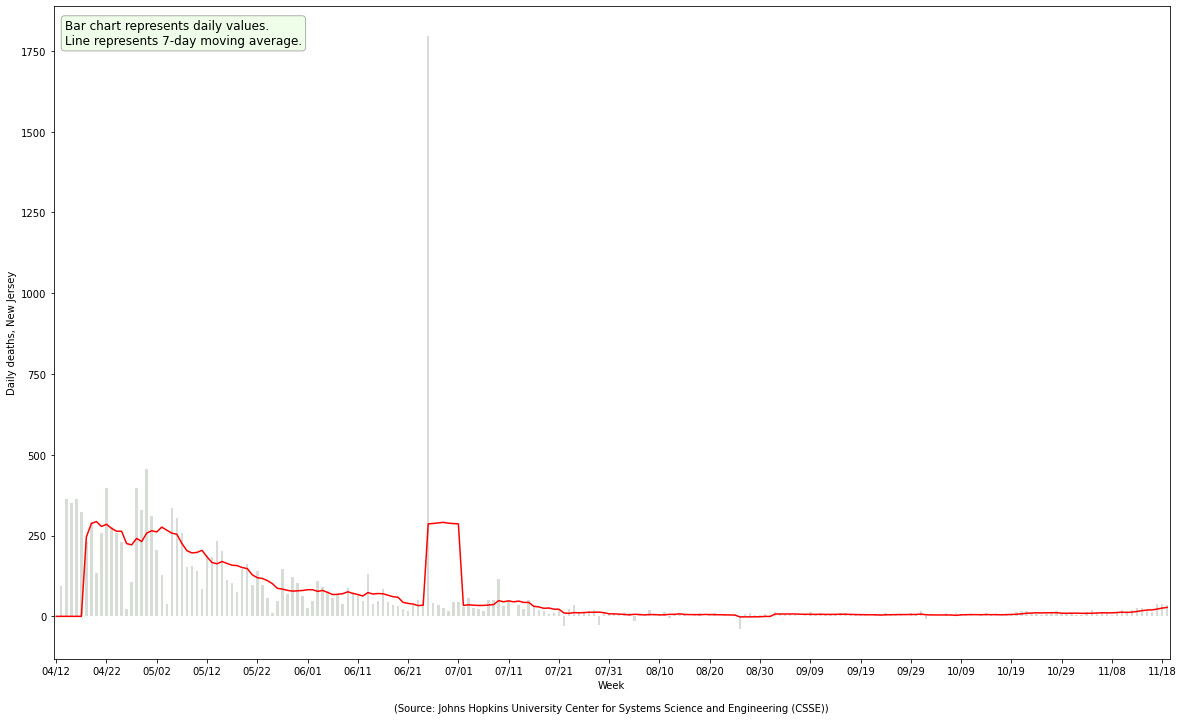

In [30]:
plot_daily_stats(df, 
                 source=SOURCE,
                 metric=MetricType.DEATHS,
                 region='New Jersey',
                 moving_average=True,
                 image_file="jhu-nj-deaths-daily.png");

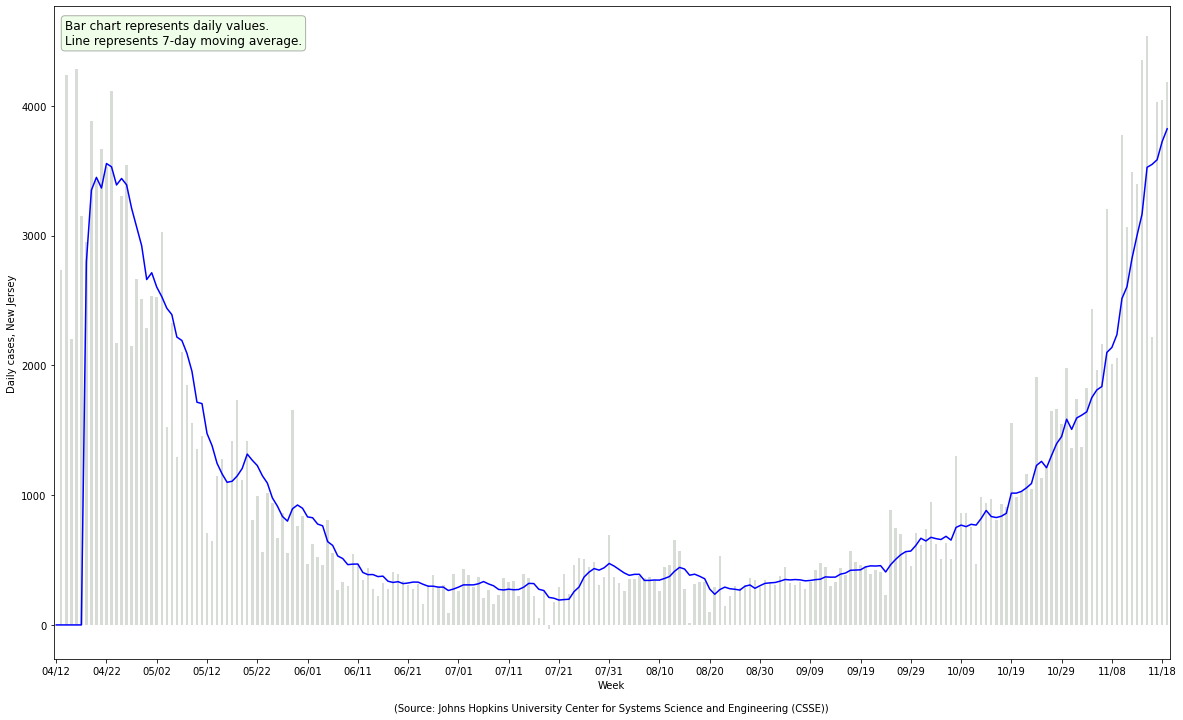

In [31]:
plot_daily_stats(df, 
                 source=SOURCE,
                 metric=MetricType.CASES,
                 region='New Jersey',
                 moving_average=True,
                 image_file="jhu-nj-cases-daily.png");

#### New York

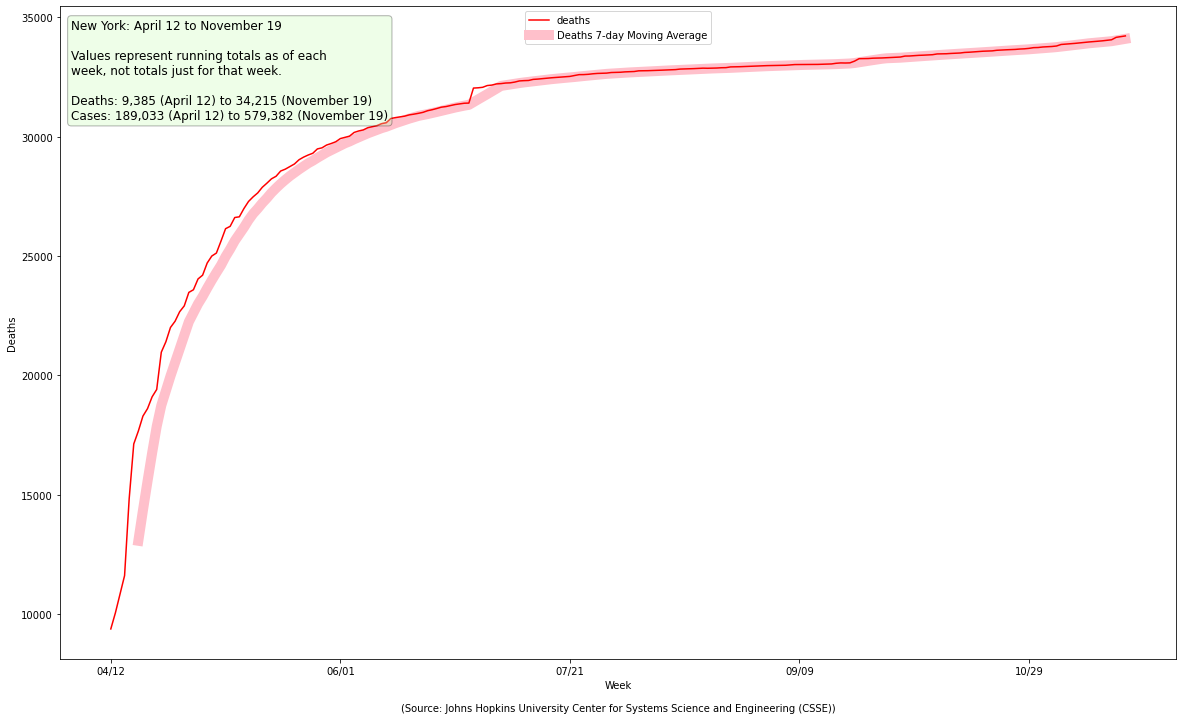

In [32]:
plot_state(df, SOURCE, 'New York', image_file='jhu-ny-deaths.png', metrics={MetricType.DEATHS}, moving_average=True);

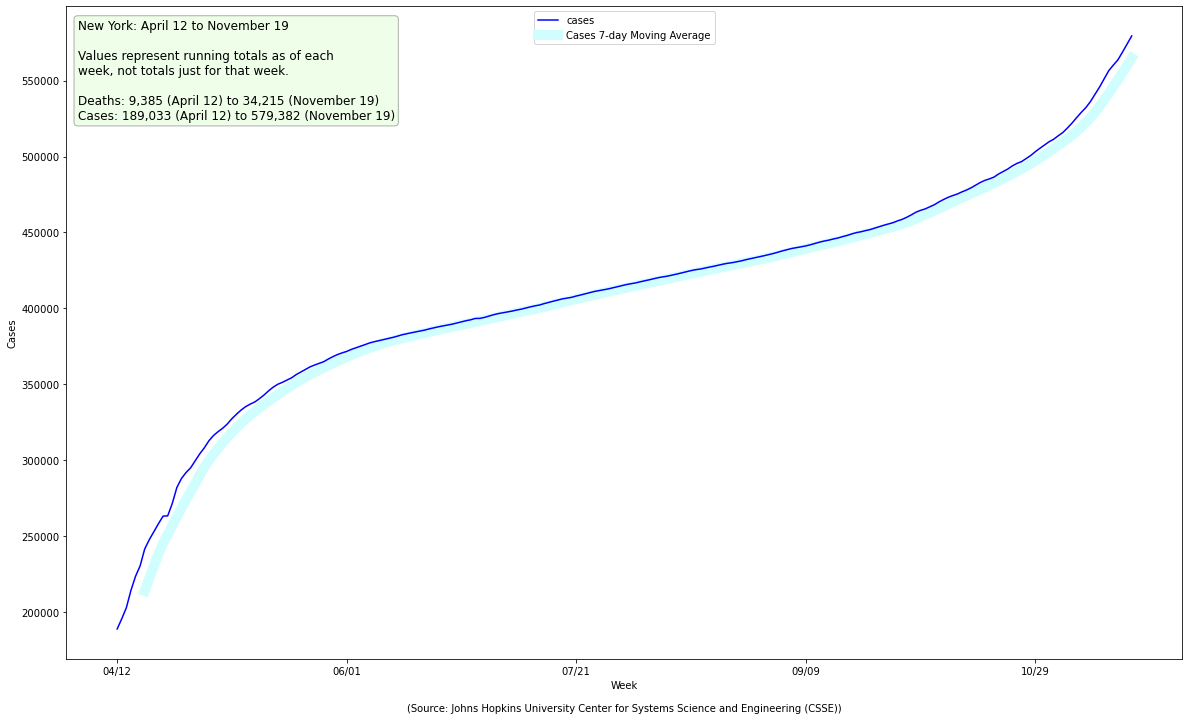

In [33]:
plot_state(df, SOURCE, 'New York', image_file='jhu-ny-cases.png', metrics={MetricType.CASES}, moving_average=True);

#### California

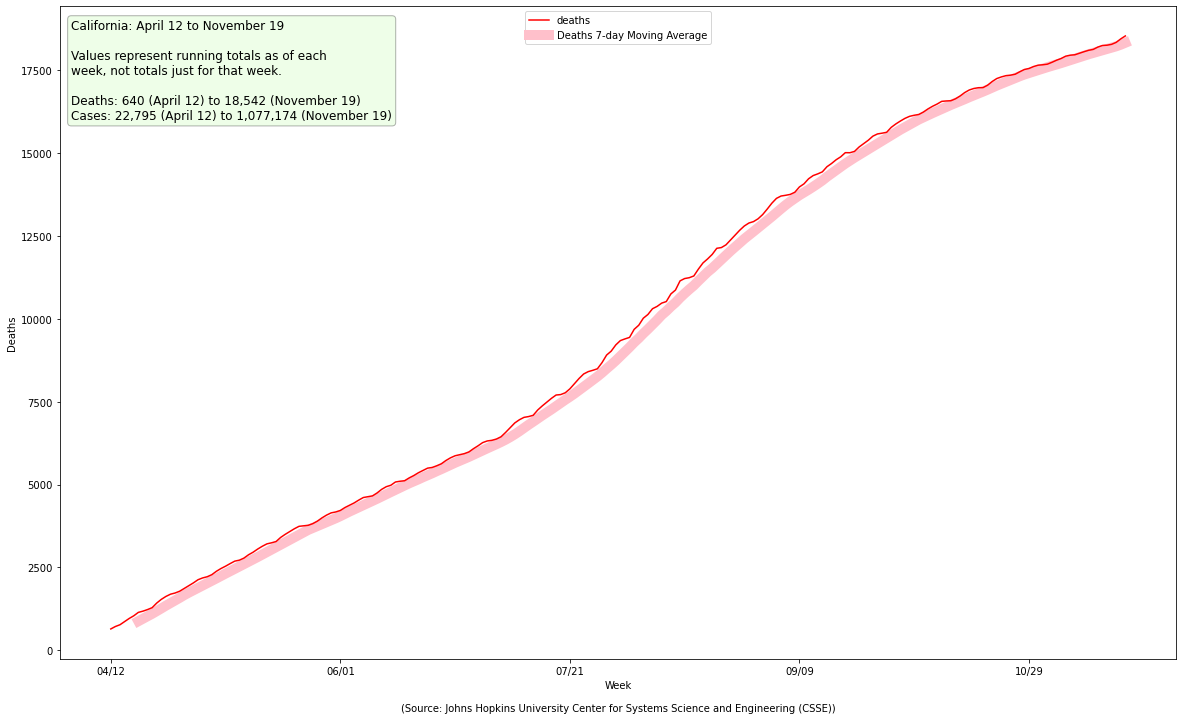

In [34]:
plot_state(df, SOURCE, 'California', image_file='jhu-ca-deaths.png', metrics={MetricType.DEATHS}, moving_average=True);

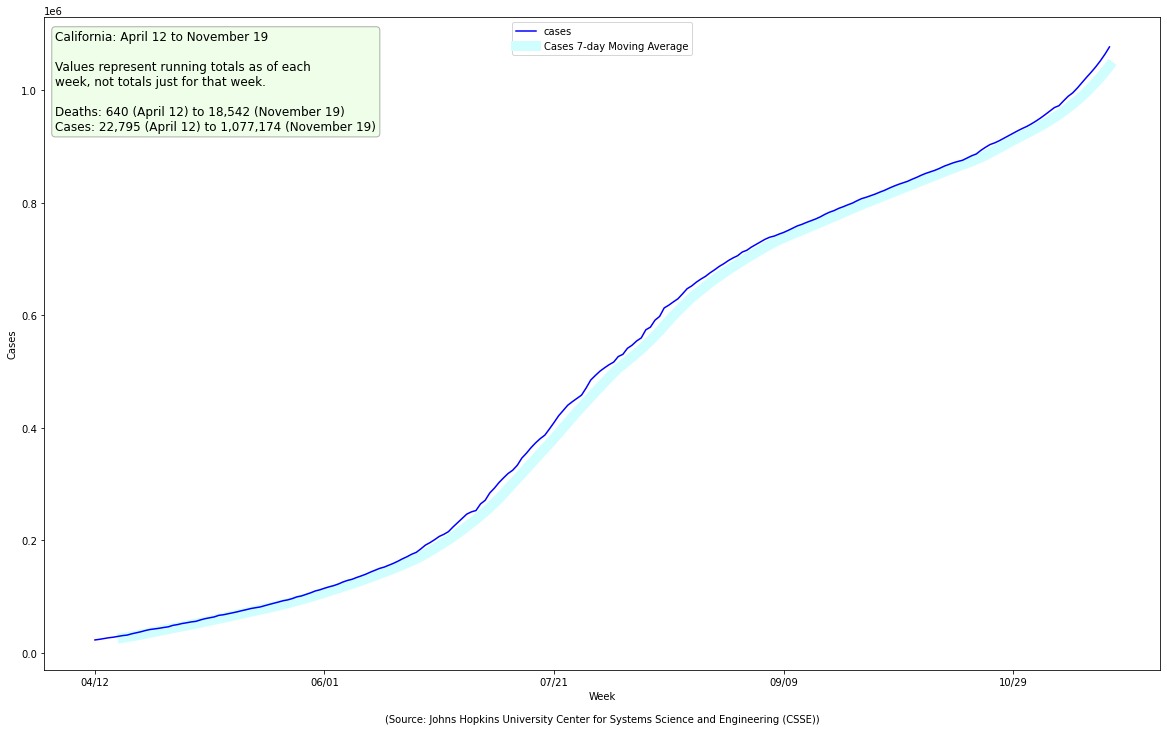

In [35]:
plot_state(df, SOURCE, 'California', image_file='jhu-ca-cases.png', metrics={MetricType.CASES}, moving_average=True);

#### Washington

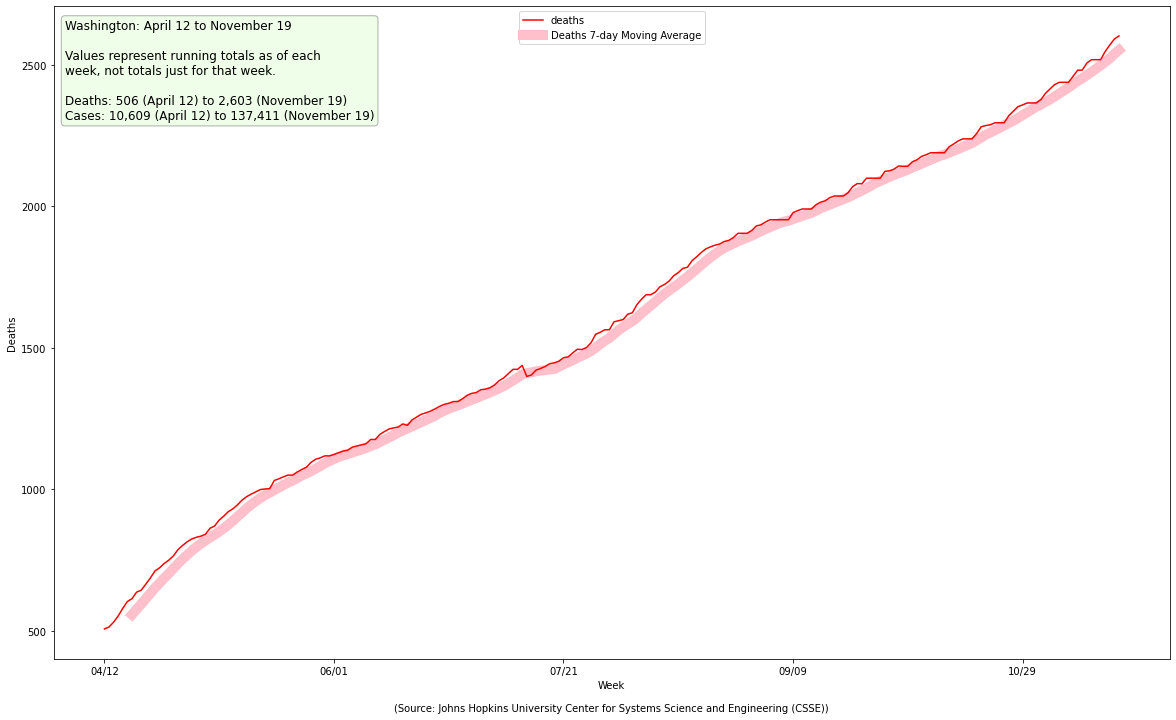

In [36]:
plot_state(df, SOURCE, 'Washington', image_file='jhu-wa-deaths.png', metrics={MetricType.DEATHS}, moving_average=True);

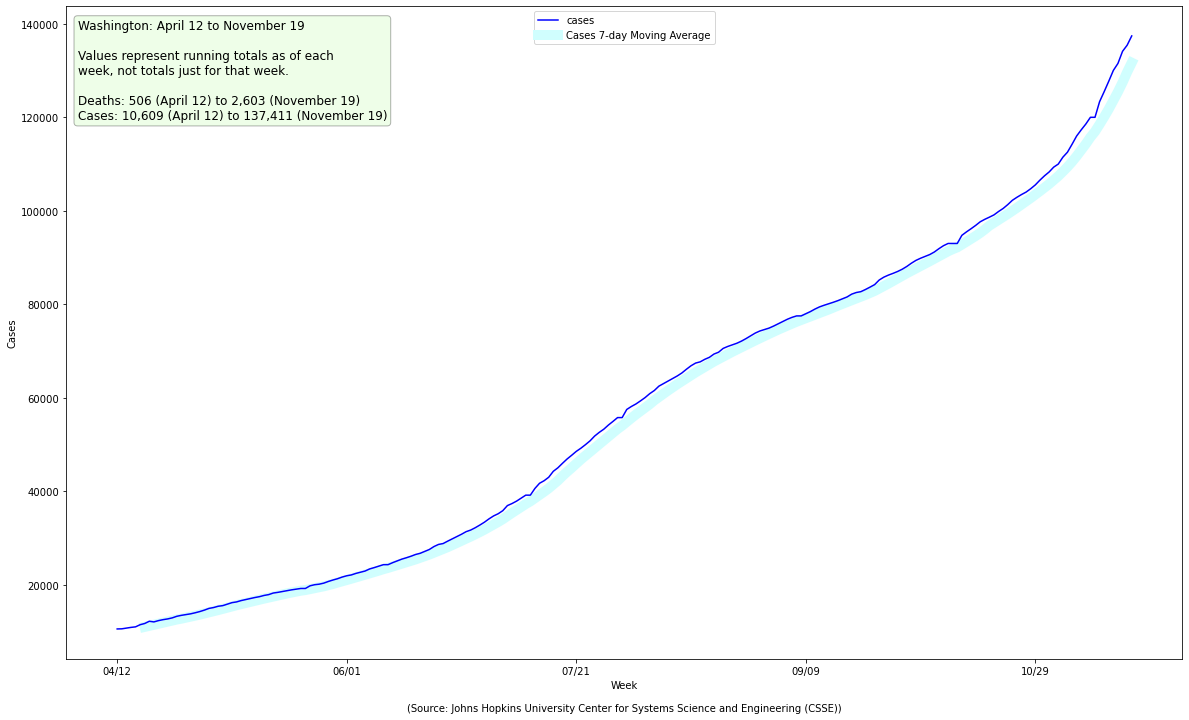

In [37]:
plot_state(df, SOURCE, 'Washington', image_file='jhu-wa-cases.png', metrics={MetricType.CASES}, moving_average=True);

#### Delaware

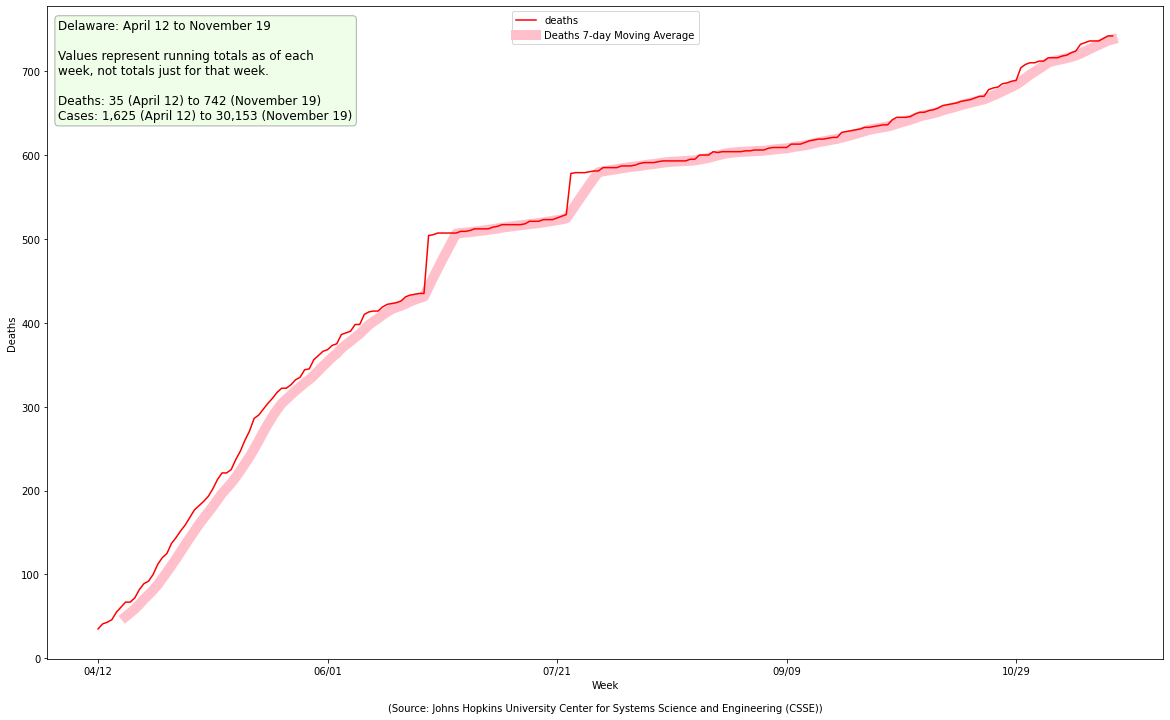

In [38]:
plot_state(df, SOURCE, 'Delaware', image_file='jhu-de-deaths.png', metrics={MetricType.DEATHS}, moving_average=True);

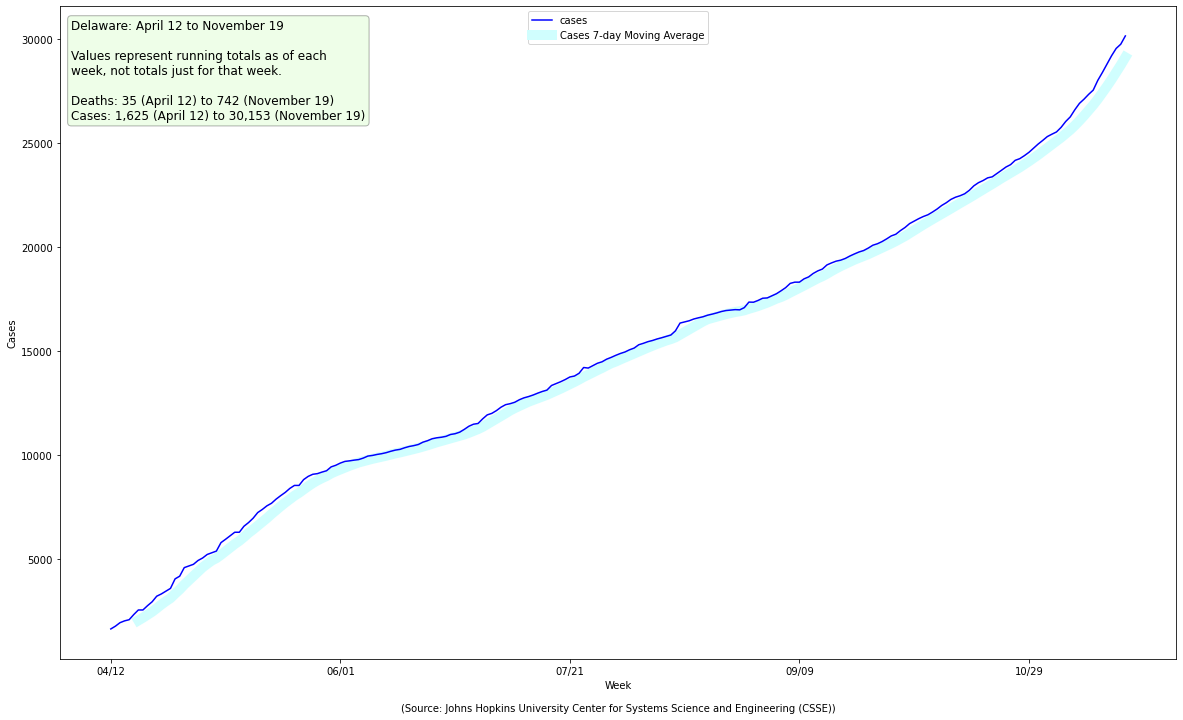

In [39]:
plot_state(df, SOURCE, 'Delaware', image_file='jhu-de-cases.png', metrics={MetricType.CASES}, moving_average=True);

#### Texas

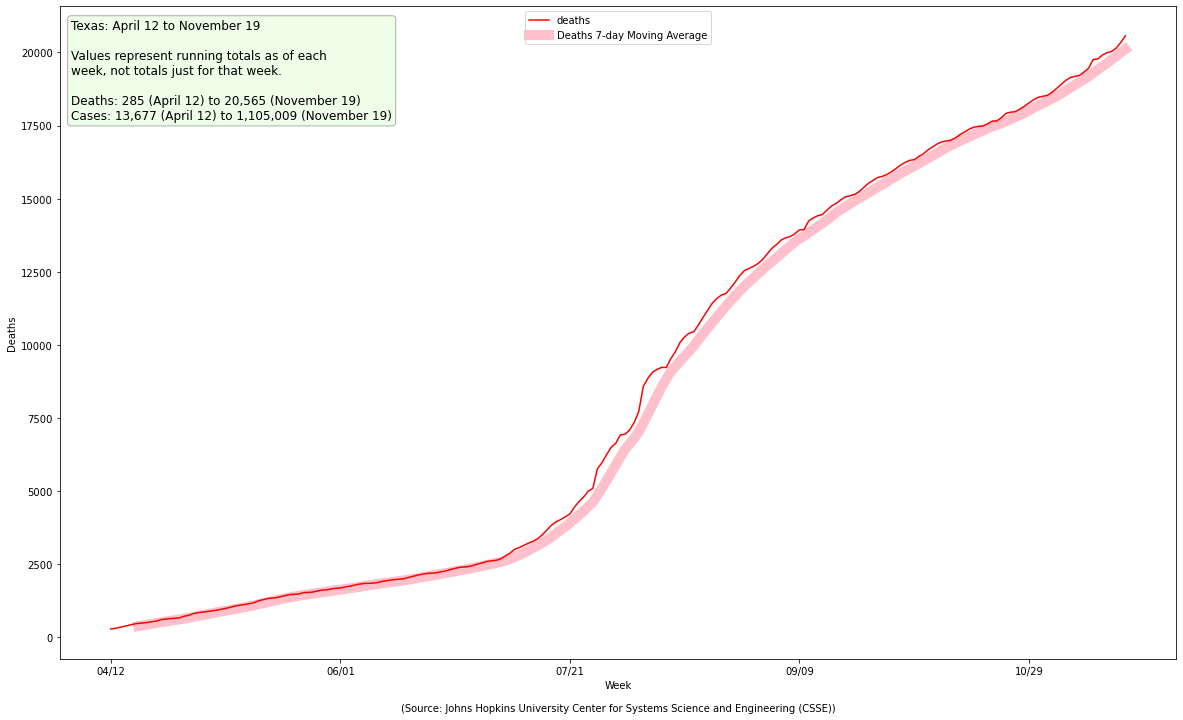

In [40]:
plot_state(df, SOURCE, 'Texas', image_file='jhu-tx-deaths.png', metrics={MetricType.DEATHS}, moving_average=True);

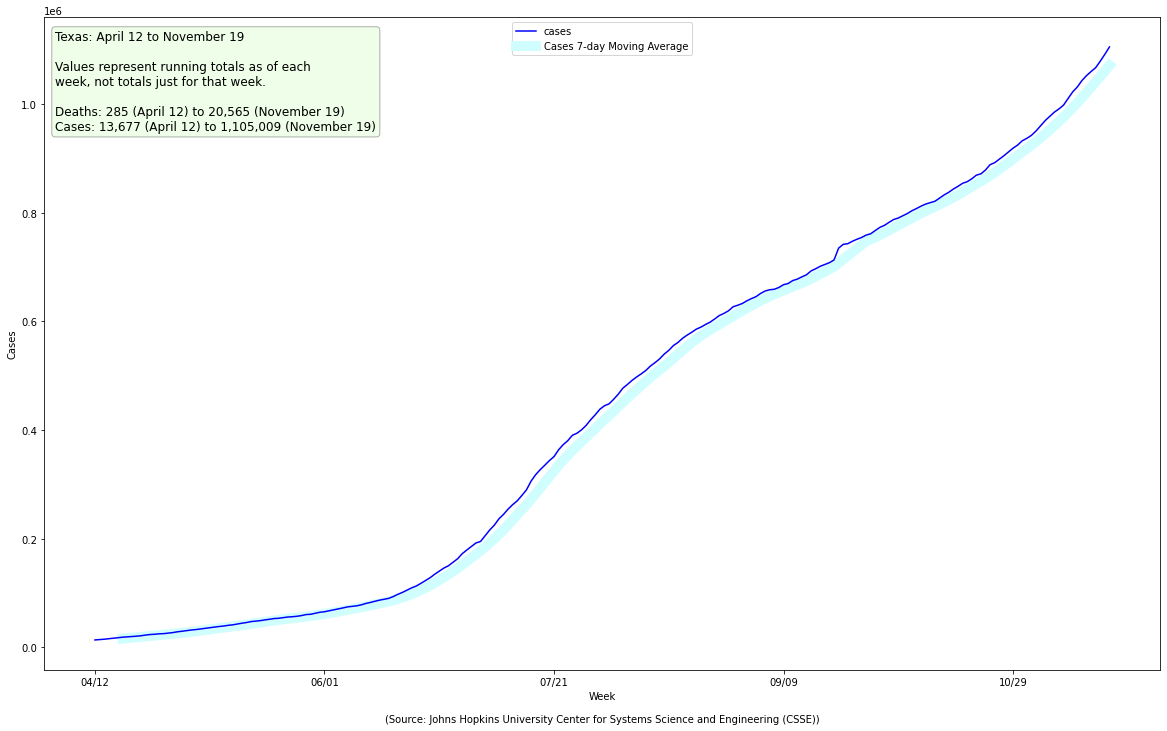

In [41]:
plot_state(df, SOURCE, 'Texas', image_file='jhu-tx-cases.png', metrics={MetricType.CASES}, moving_average=True);

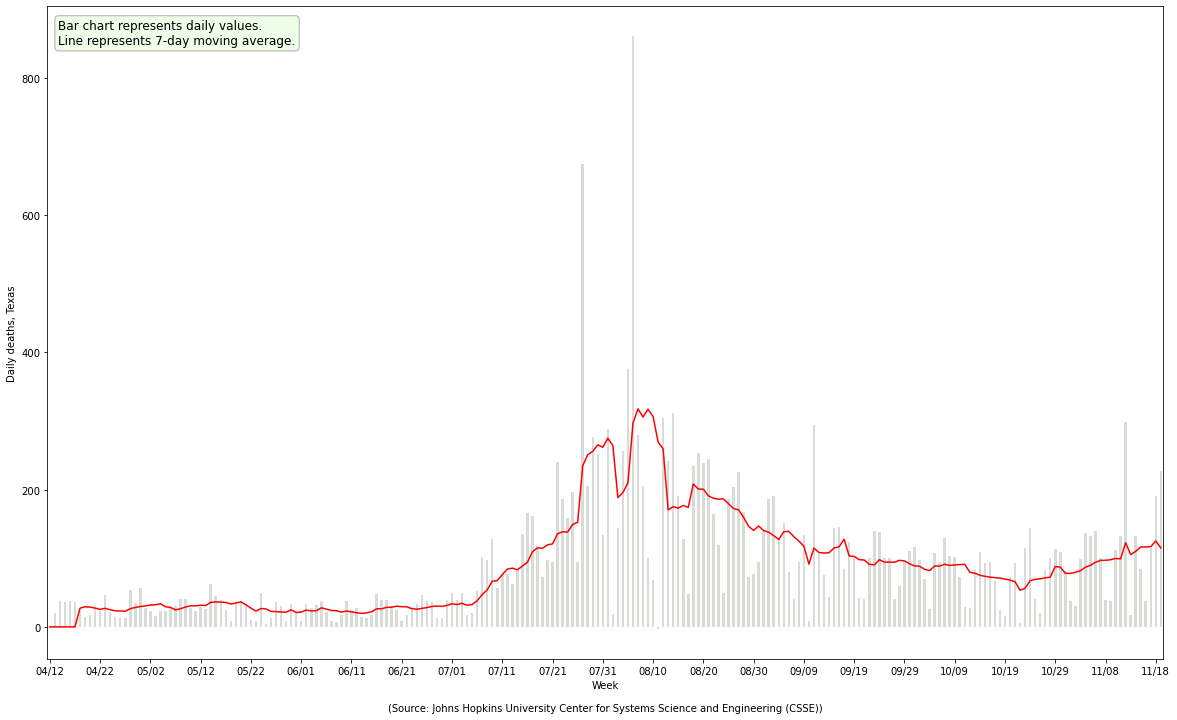

In [42]:
plot_daily_stats(df, SOURCE, region='Texas', metric=MetricType.DEATHS, moving_average=True, image_file="jhu-tx-daily-deaths.png");

#### Georgia

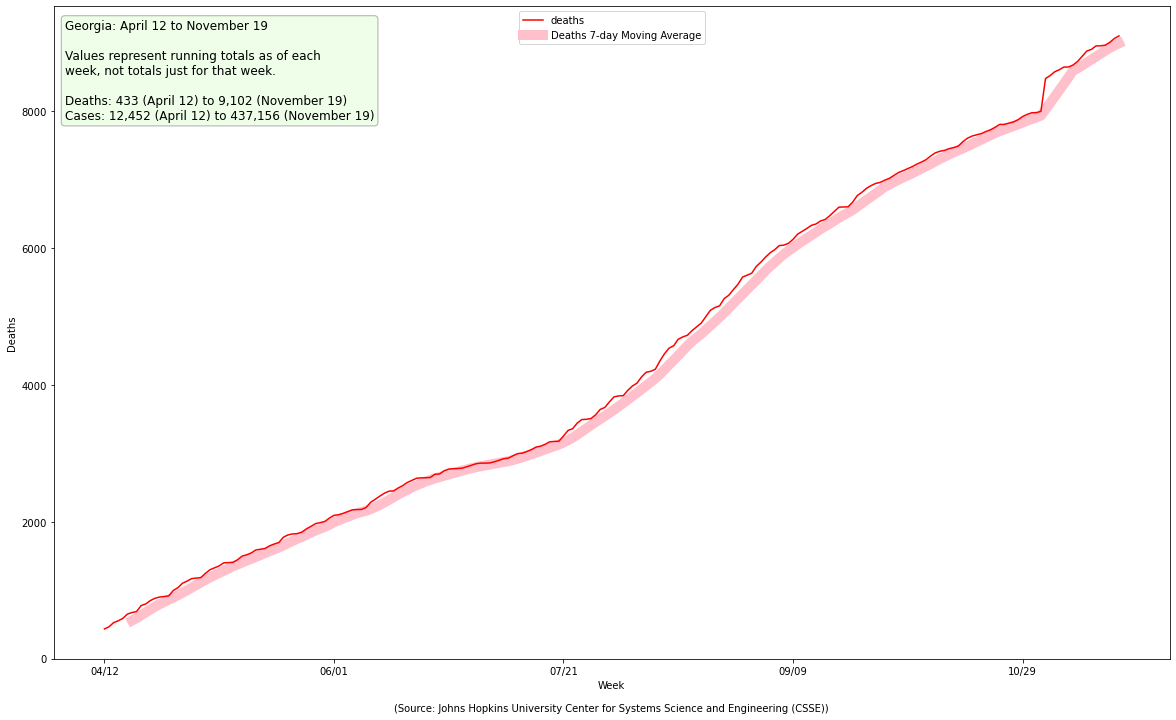

In [43]:
plot_state(df, SOURCE, 'Georgia', image_file='jhu-ga-deaths.png', metrics={MetricType.DEATHS}, moving_average=True);

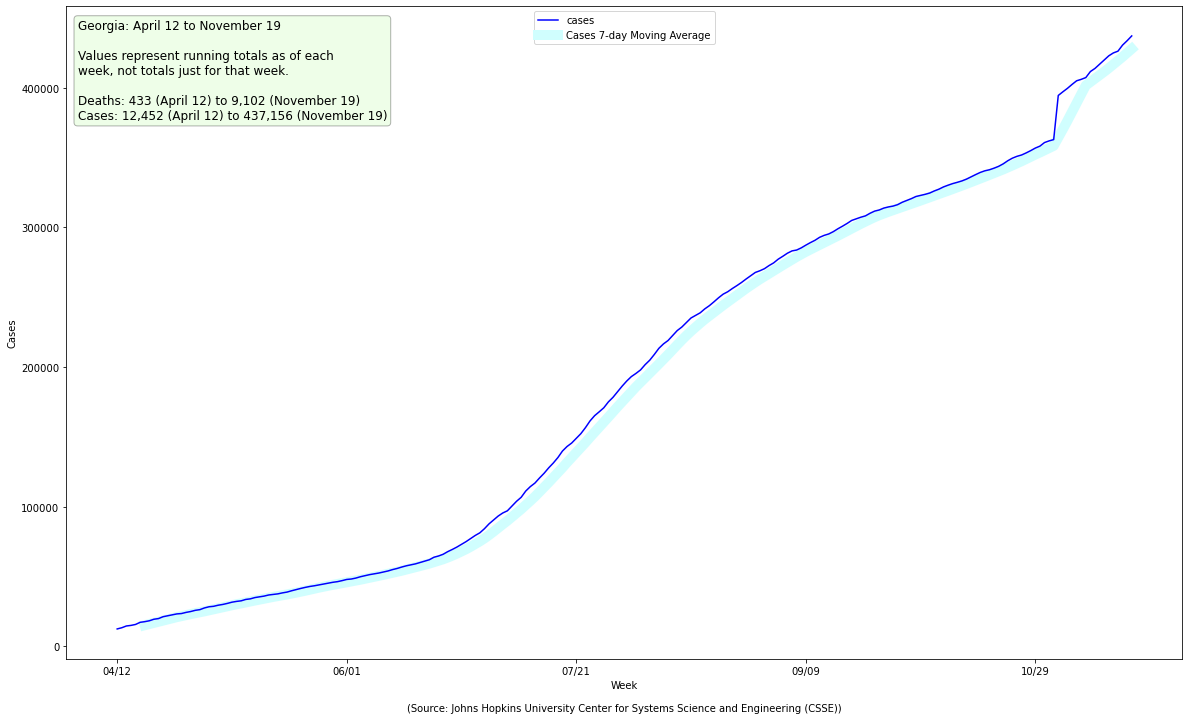

In [44]:
plot_state(df, SOURCE, 'Georgia', image_file='jhu-ga-cases.png', metrics={MetricType.CASES}, moving_average=True);

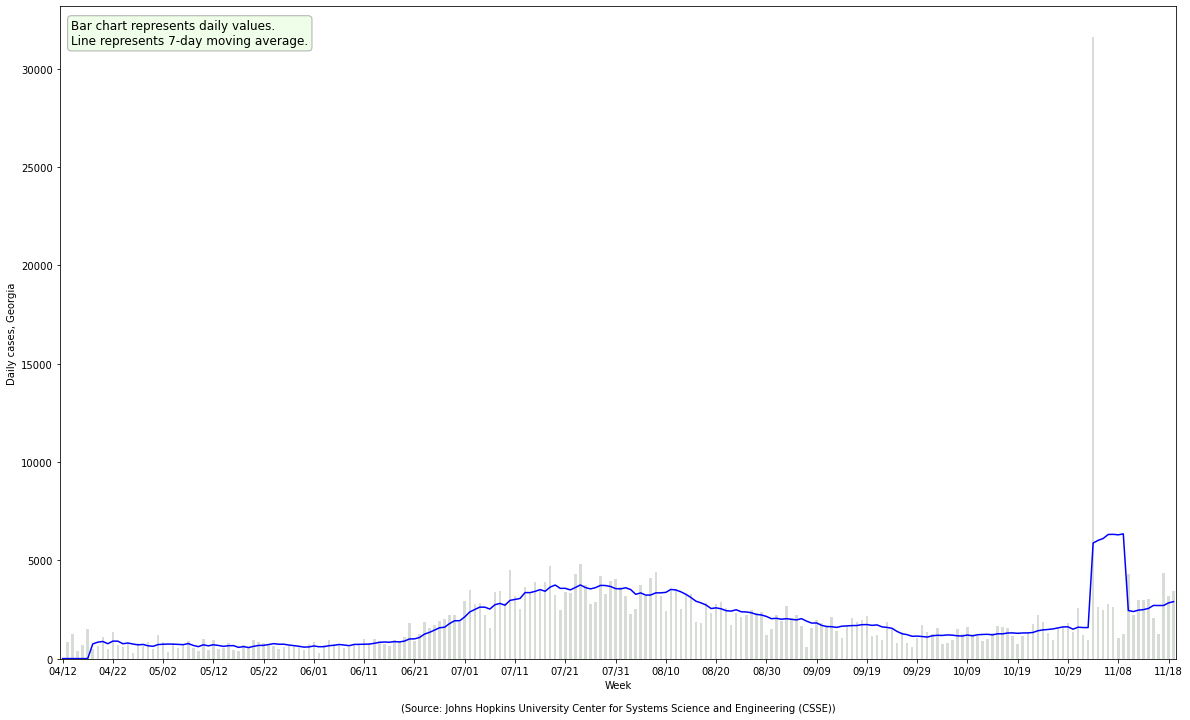

In [45]:
plot_daily_stats(df, SOURCE, region='Georgia', metric=MetricType.CASES, moving_average=True, image_file="jhu-ga-daily-cases.png");

#### Mississippi

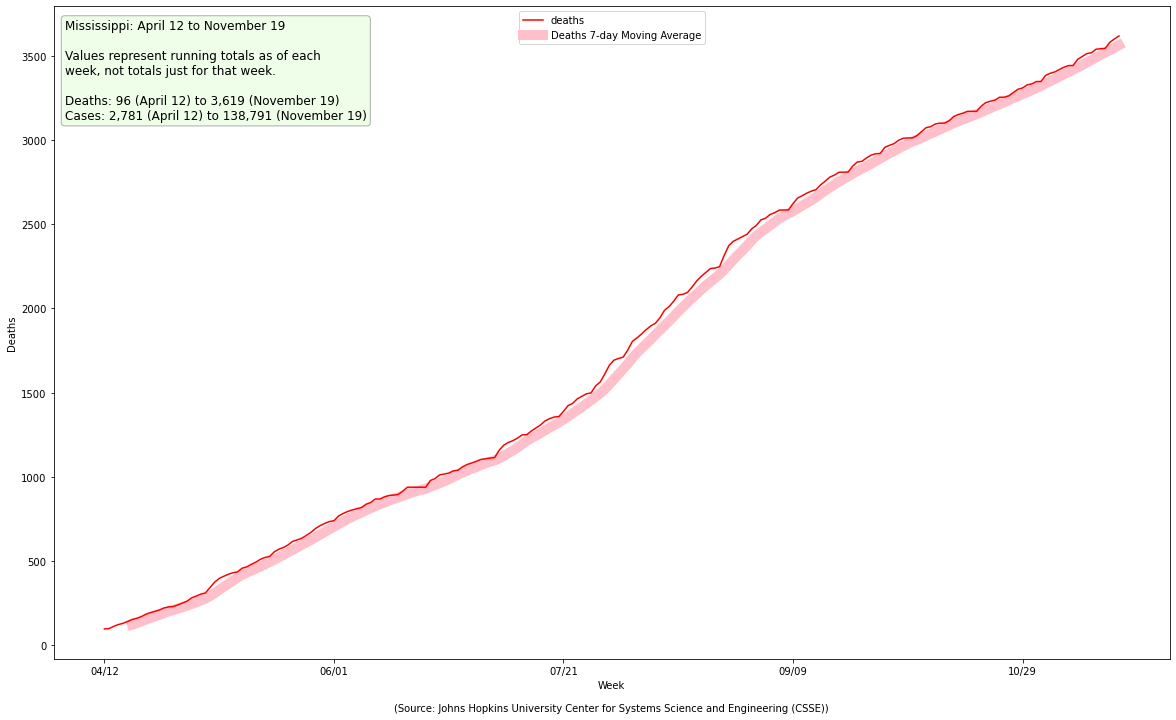

In [46]:
plot_state(df, SOURCE, 'Mississippi', image_file='jhu-ms-deaths.png', metrics={MetricType.DEATHS}, moving_average=True);

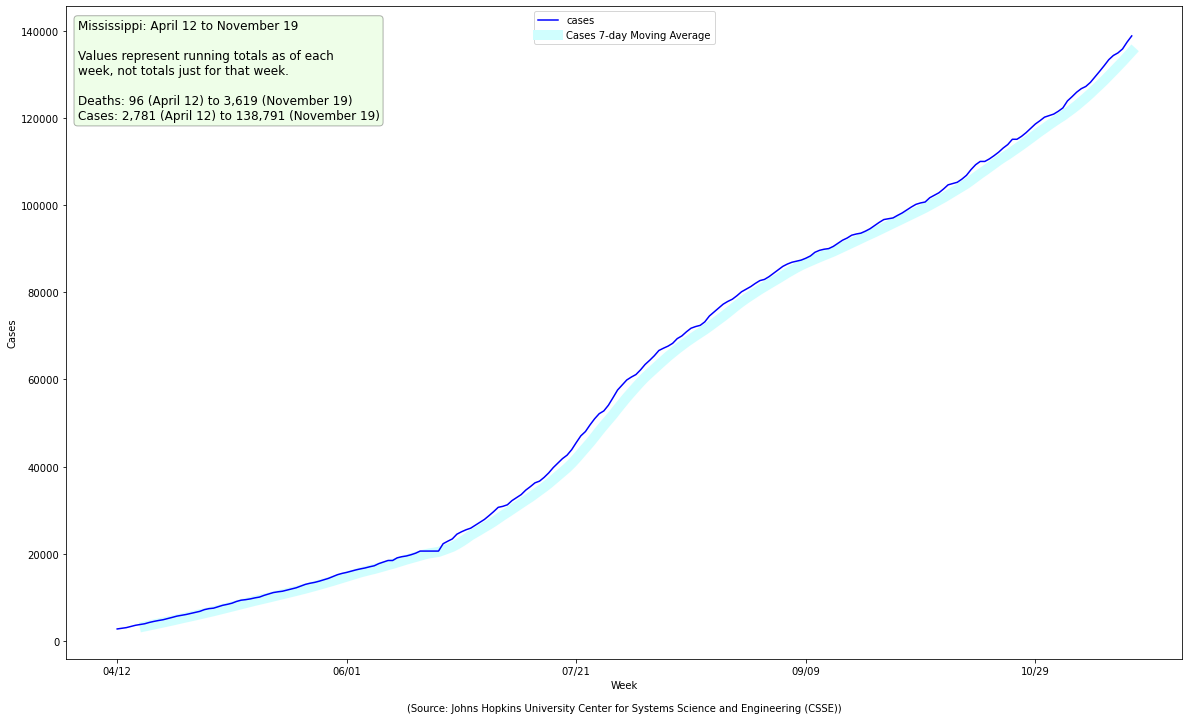

In [47]:
plot_state(df, SOURCE, 'Mississippi', image_file='jhu-ms-cases.png', metrics={MetricType.CASES}, moving_average=True);

#### Arizona

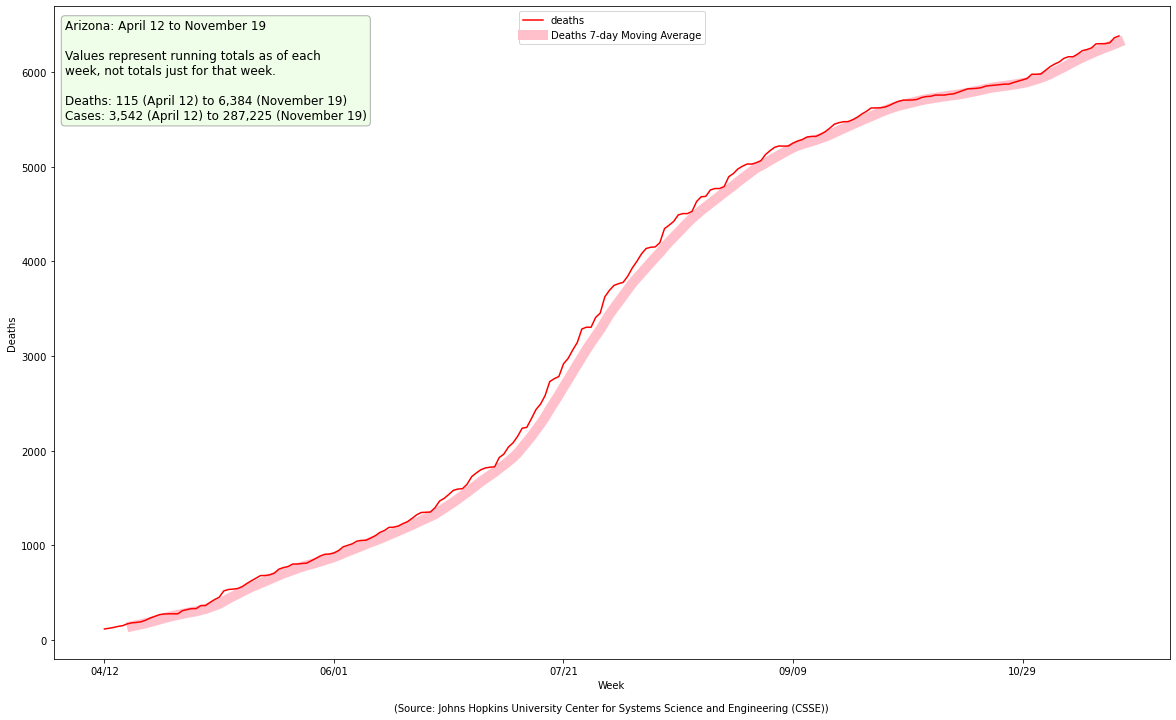

In [48]:
plot_state(df, SOURCE, 'Arizona', image_file='jhu-az-deaths.png', metrics={MetricType.DEATHS}, moving_average=True);

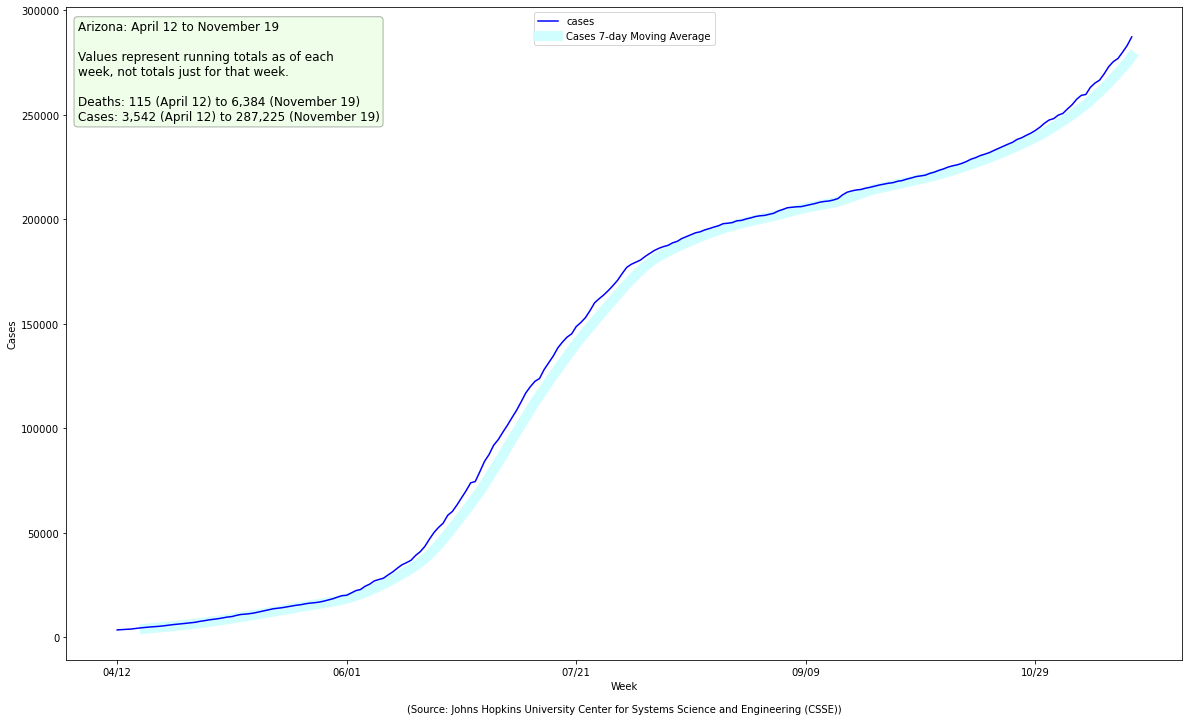

In [49]:
plot_state(df, SOURCE, 'Arizona', image_file='jhu-az-cases.png', metrics={MetricType.CASES}, moving_average=True);

#### Florida

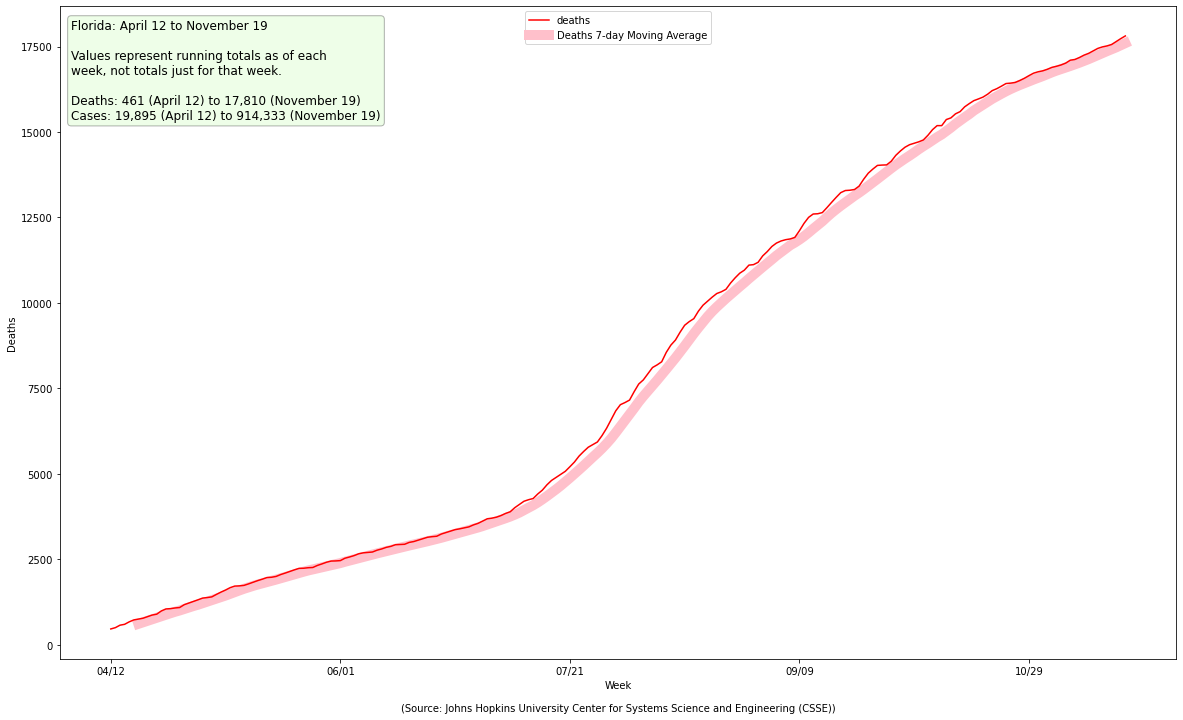

In [50]:
plot_state(df, SOURCE, 'Florida', image_file='jhu-fl-deaths.png', metrics={MetricType.DEATHS}, moving_average=True);

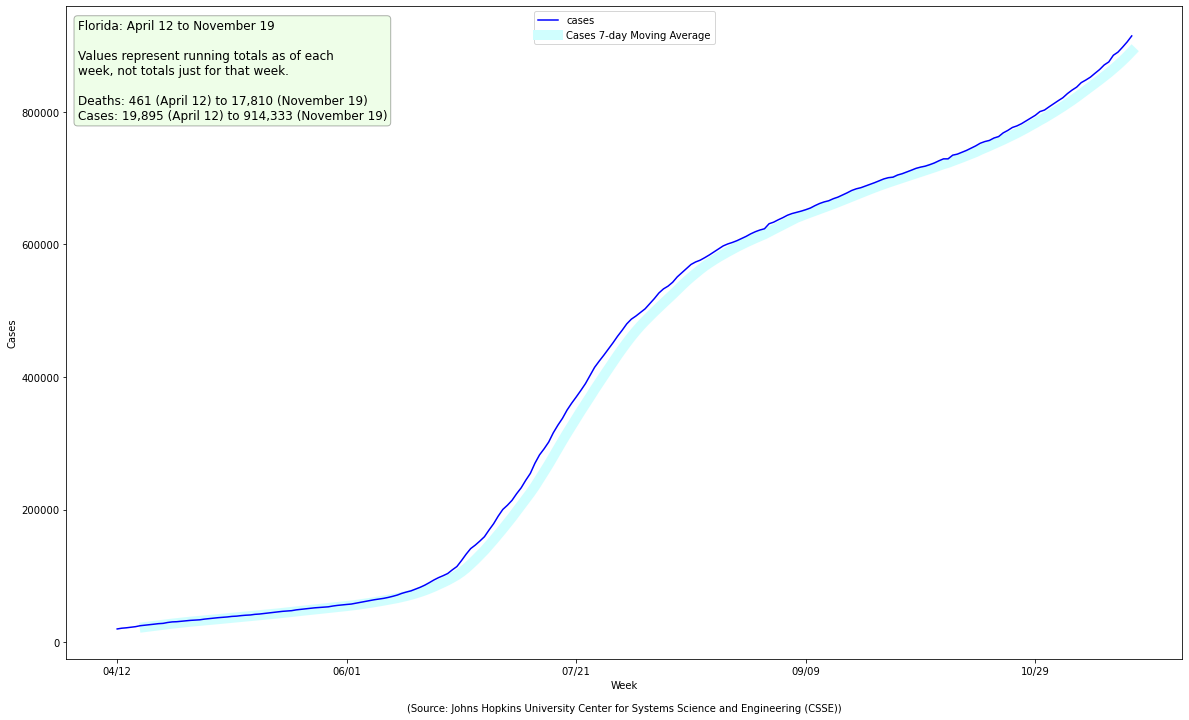

In [51]:
plot_state(df, SOURCE, 'Florida', image_file='jhu-fl-cases.png', metrics={MetricType.CASES}, moving_average=True);

### South Carolina

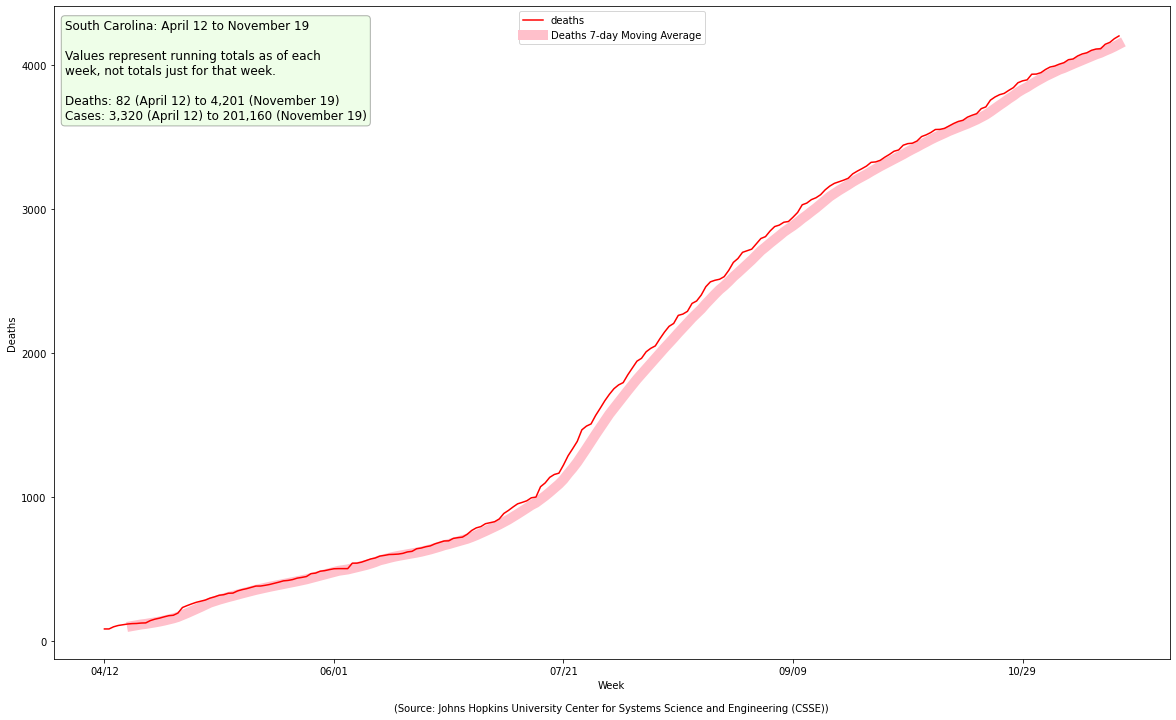

In [52]:
plot_state(df, SOURCE, 'South Carolina', image_file='jhu-sc-deaths.png', metrics={MetricType.DEATHS}, moving_average=True);

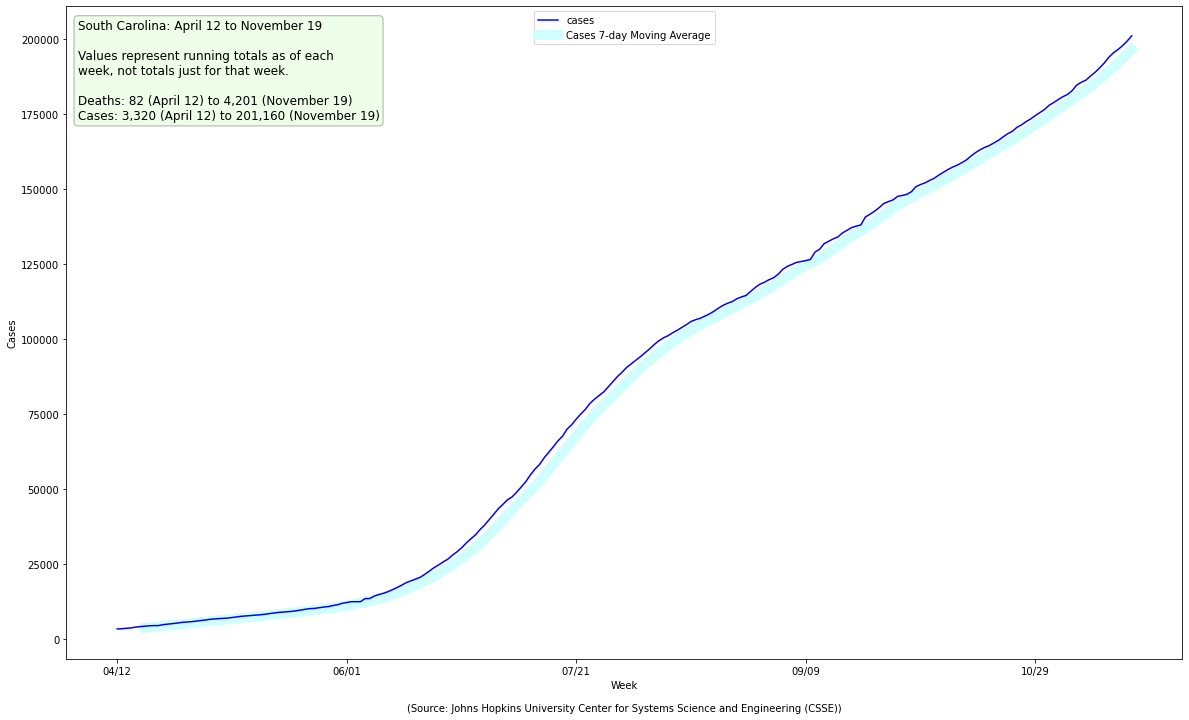

In [53]:
plot_state(df, SOURCE, 'South Carolina', image_file='jhu-sc-cases.png', metrics={MetricType.CASES}, moving_average=True);

#### Oklahoma

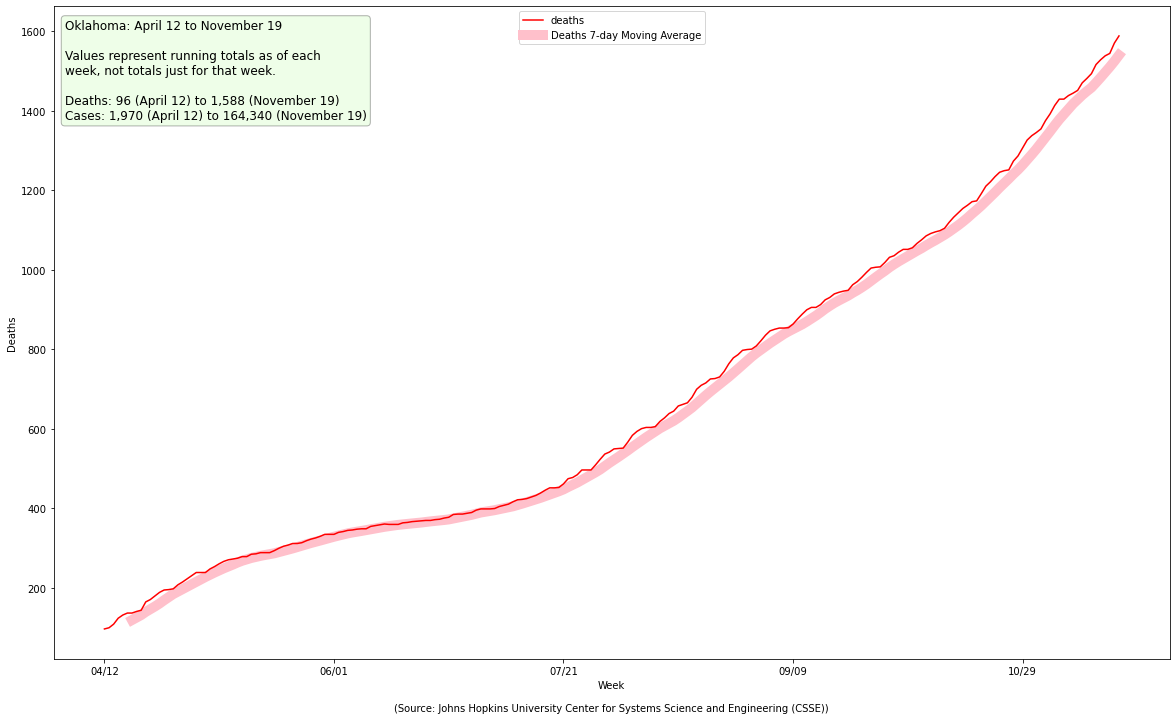

In [54]:
plot_state(df, SOURCE, 'Oklahoma', image_file='jhu-ok-deaths.png', metrics={MetricType.DEATHS}, moving_average=True);

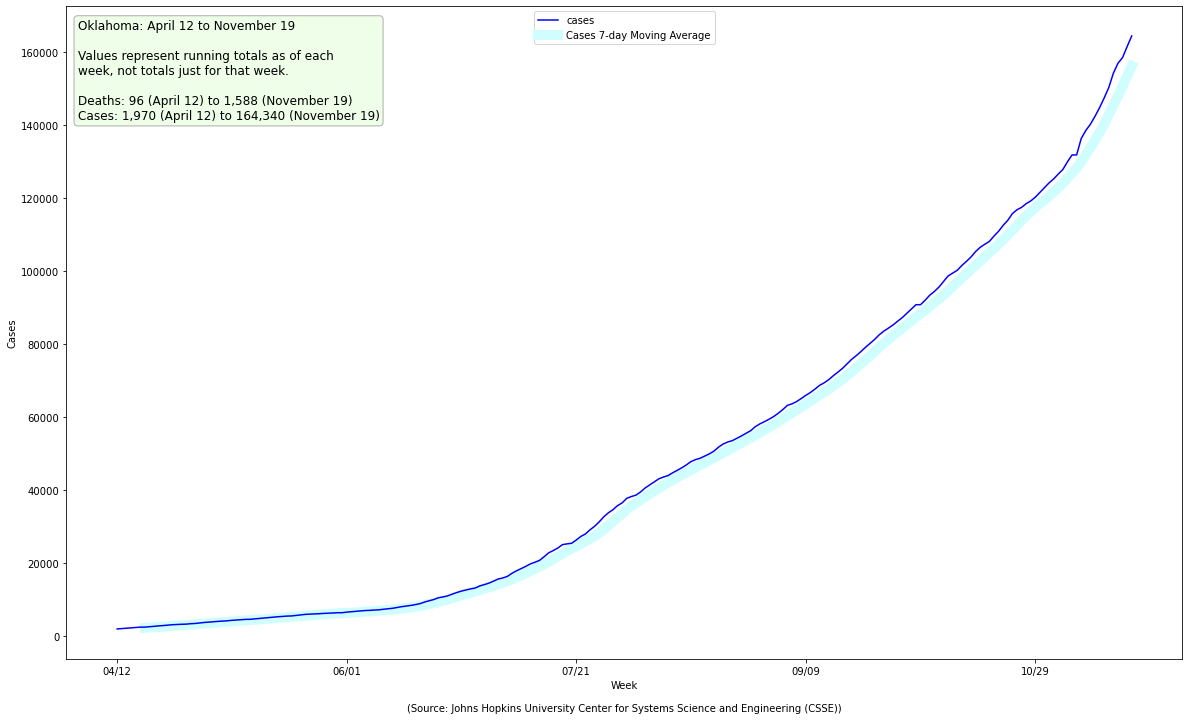

In [55]:
plot_state(df, SOURCE, 'Oklahoma', image_file='jhu-ok-cases.png', metrics={MetricType.CASES}, moving_average=True);

## Multistate

### Northeast states

Data from some of the states that were hardest hit early on.

In [56]:
ne_states = ('Connecticut', 'New York', 'New Jersey', 'Pennsylvania', 'Delaware', 'Ohio')

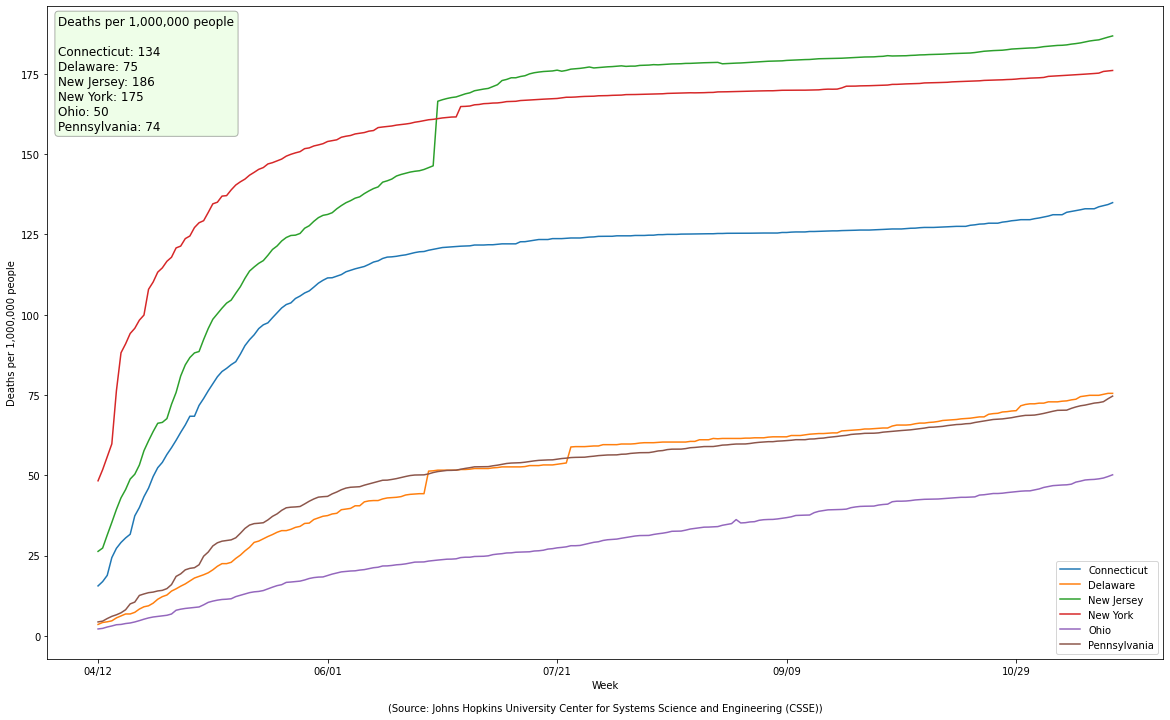

In [57]:
plot_states(df, SOURCE, ne_states, per_n=1_000_000, populations=populations, metric=MetricType.DEATHS,
            image_file='jhu-ne-states-deaths-per-capita.png');

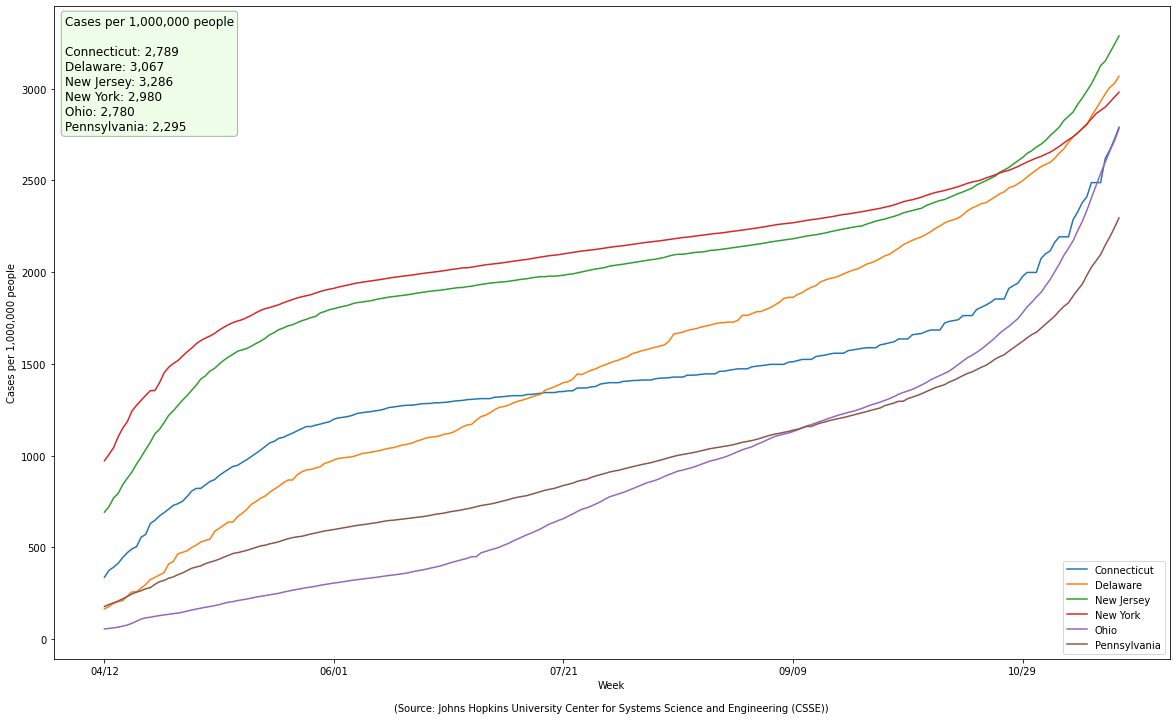

In [58]:
plot_states(df, SOURCE, ne_states, per_n=1_000_000, populations=populations, metric=MetricType.CASES,
            image_file='jhu-ne-states-cases-per-capita.png');

### South and southwestern states

Data from some of the states hard hit in mid-2020.

In [59]:
s_sw_states = ('Arizona', 'Texas', 'Oklahoma', 'South Carolina', 'Utah', 'California', 'Florida')

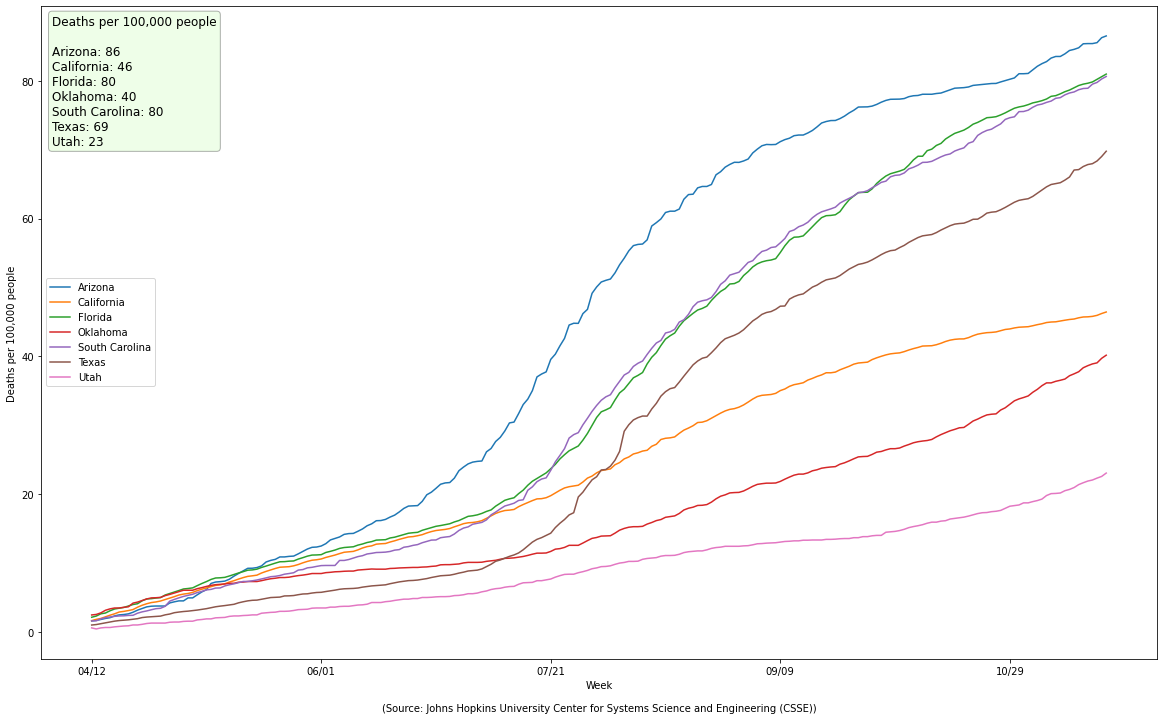

In [60]:
plot_states(df, SOURCE, s_sw_states, per_n=100_000, populations=populations, metric=MetricType.DEATHS,
            legend_loc='center left', image_file='jhu-s-sw-states-deaths-per-capita.png');

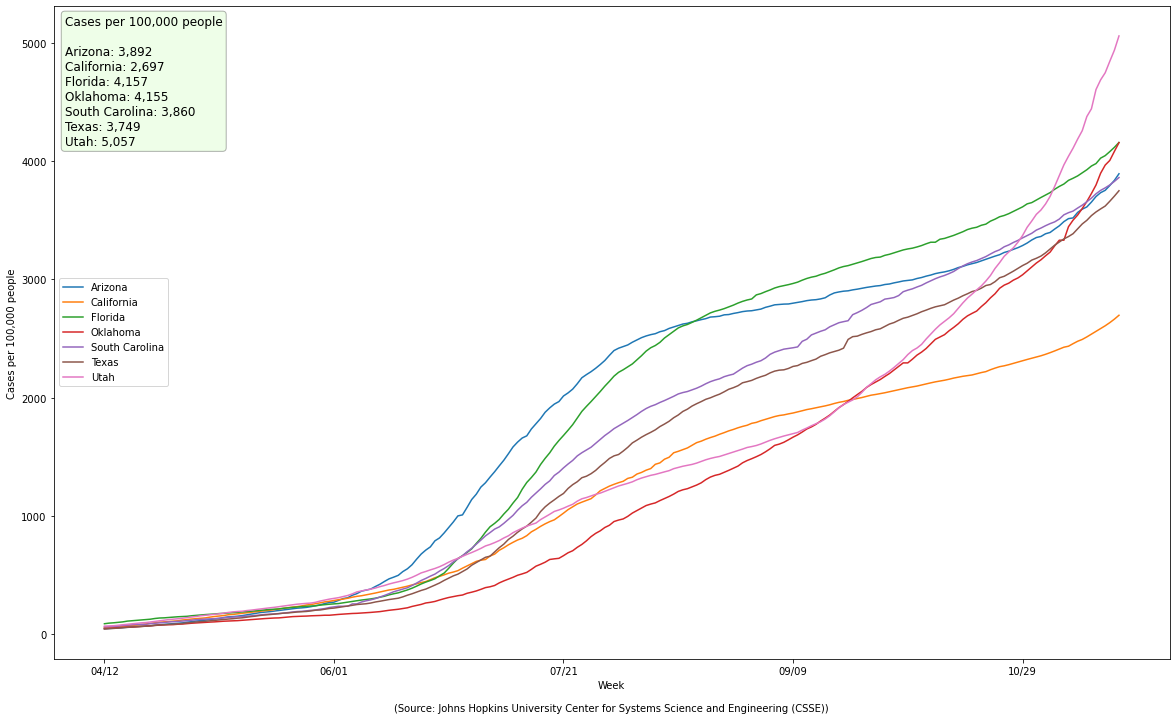

In [61]:
plot_states(df, SOURCE, s_sw_states, per_n=100_000, populations=populations, metric=MetricType.CASES,
            legend_loc='center left', image_file='jhu-s-sw-states-cases-per-capita.png');

How are some of these states doing, compared to Pennsylvania (my home state)?

In [62]:
s_sw_plus_pa = s_sw_states + ('Pennsylvania',)

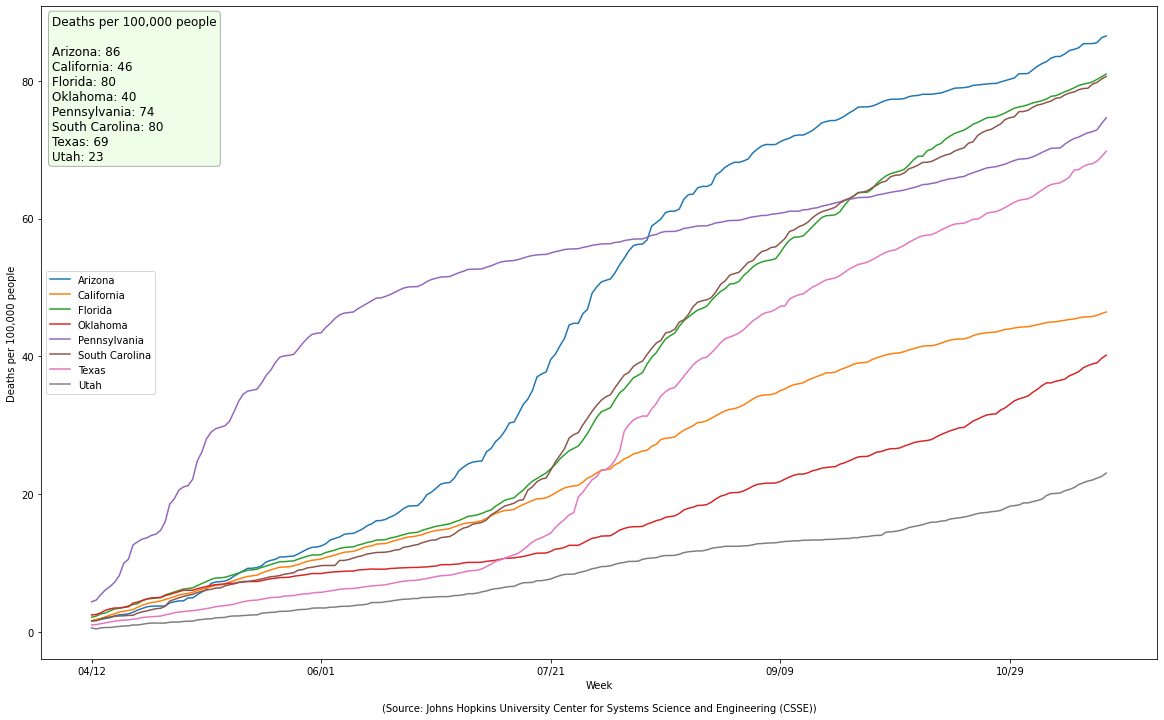

In [63]:
plot_states(df, SOURCE, s_sw_plus_pa, per_n=100_000, populations=populations, metric=MetricType.DEATHS, 
            legend_loc='center left', image_file='jhu-s-sw-states-with-pa-deaths-per-capita.png');

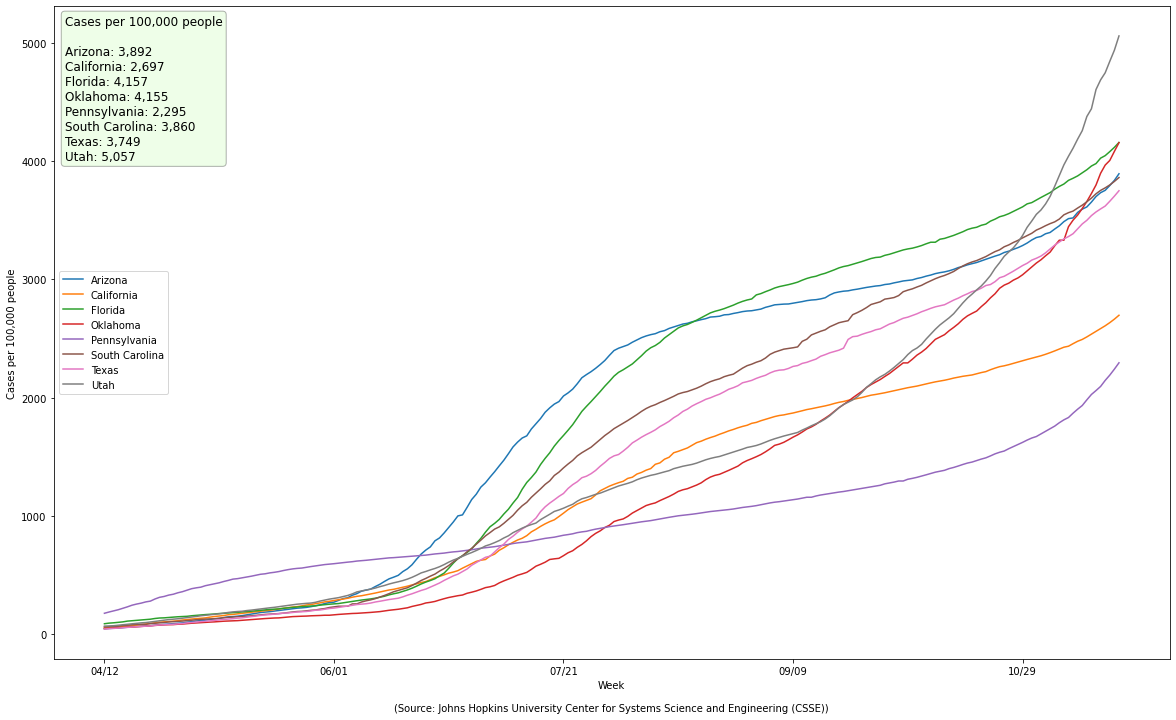

In [64]:
plot_states(df, SOURCE, s_sw_plus_pa, per_n=100_000, populations=populations, metric=MetricType.CASES,
            legend_loc='center left', image_file='jhu-s-sw-states-with-pa-cases-per-capita.png');

## Per-capita rates for all states

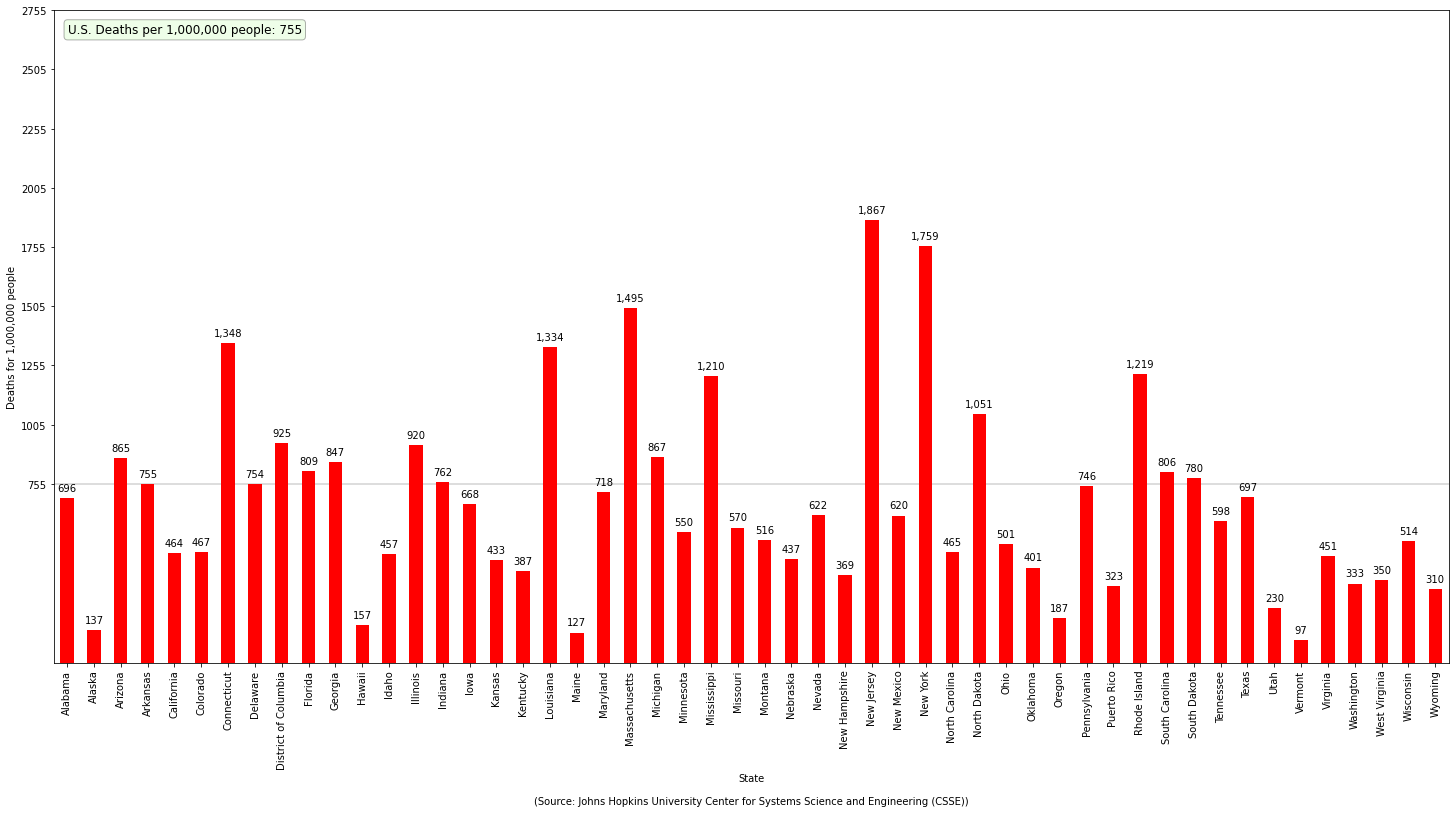

In [65]:
plot_states_per_capita(df, SOURCE, populations, image_file='jhu-state-deaths-per-capita.png');

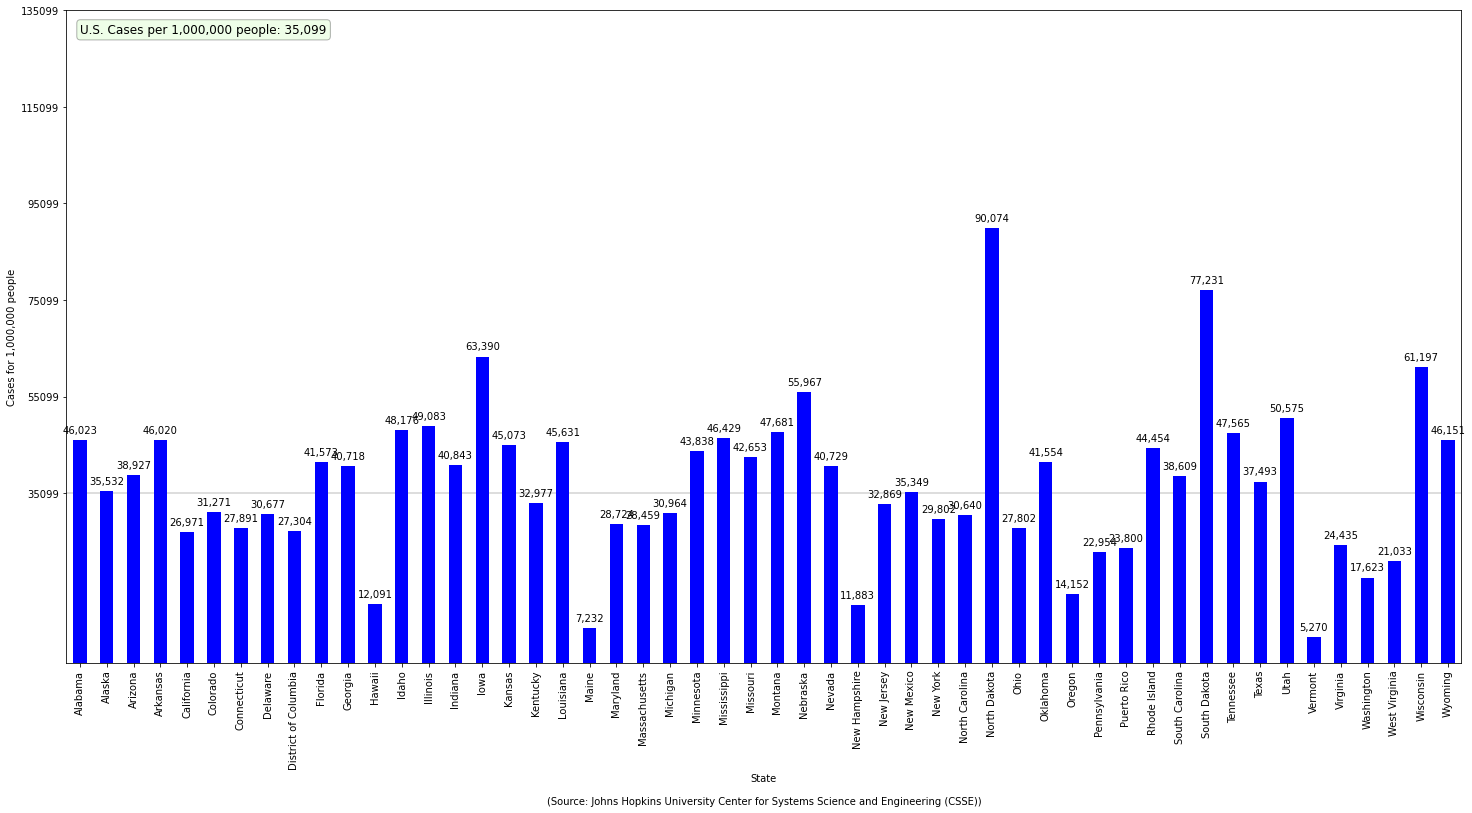

In [66]:
plot_states_per_capita(df, SOURCE, populations, metric=MetricType.CASES, image_file='jhu-state-cases-per-capita.png');

## Counties

### Some select Pennsylvania counties

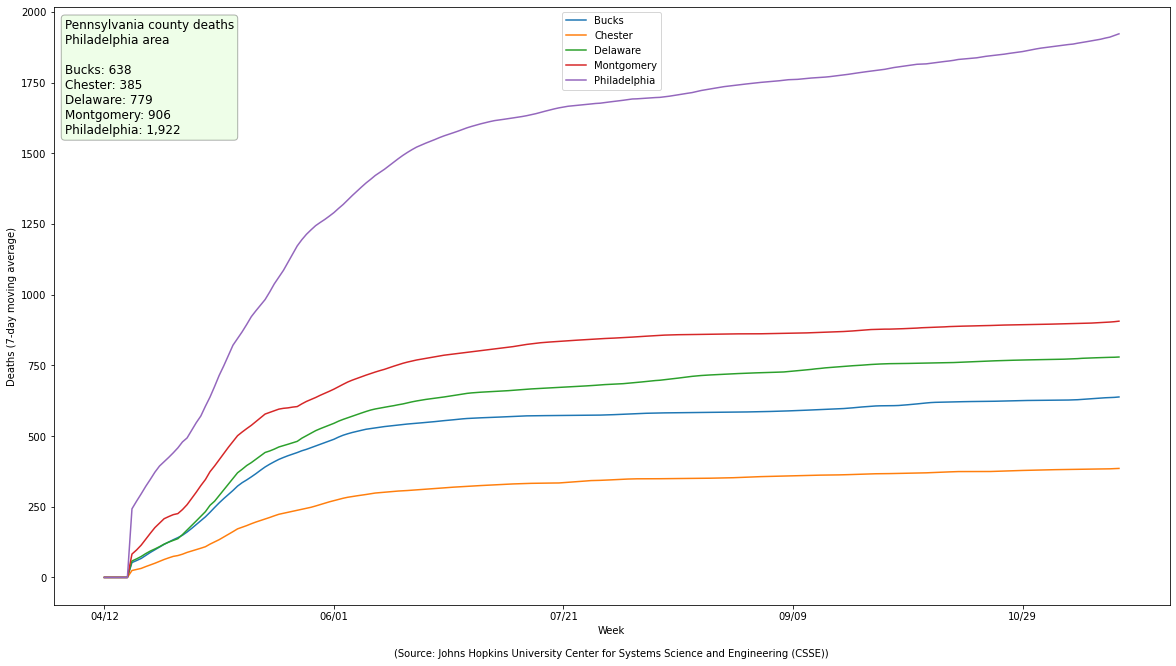

In [67]:
philly_area_counties = ('Montgomery', 'Philadelphia', 'Chester', 'Bucks', 'Delaware')
plot_counties(df_counties, 'Pennsylvania', philly_area_counties, source=SOURCE, moving_average=True,
              textbox_heading="Philadelphia area", metric=MetricType.DEATHS, image_file='jhu-pa-phl-area-deaths.png')

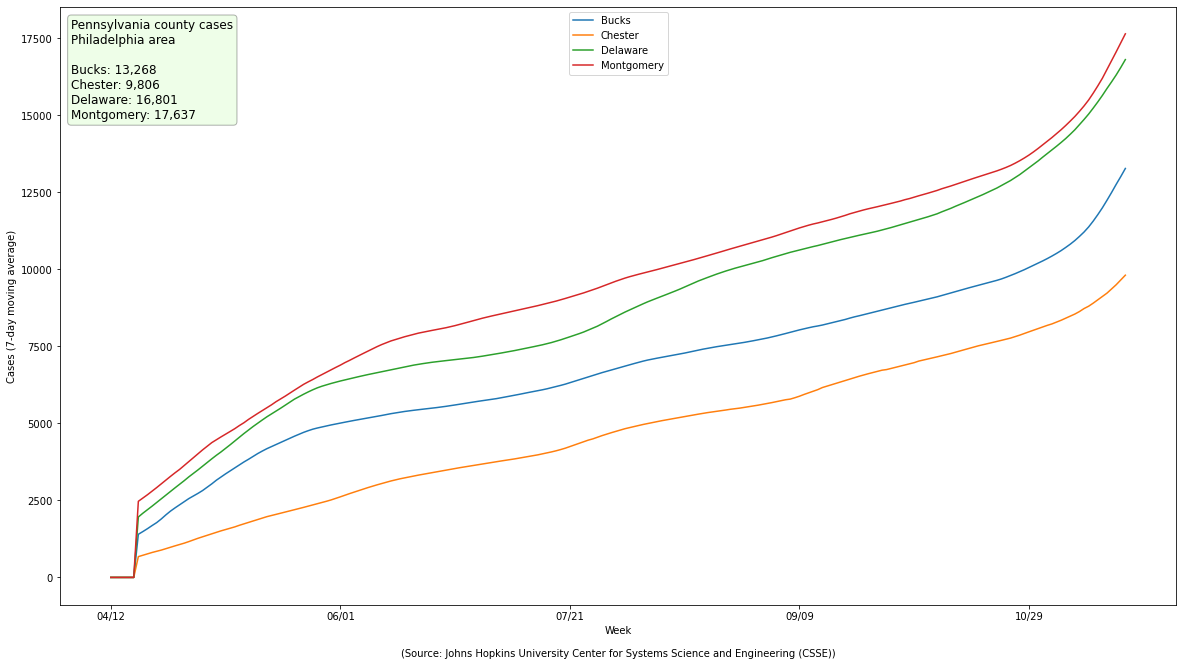

In [68]:
without_philly = set(philly_area_counties) - {'Philadelphia',}
plot_counties(df_counties, 'Pennsylvania', without_philly, source=SOURCE, moving_average=True,
              textbox_heading="Philadelphia area", metric=MetricType.CASES, image_file='jhu-pa-outside-phl-cases.png')

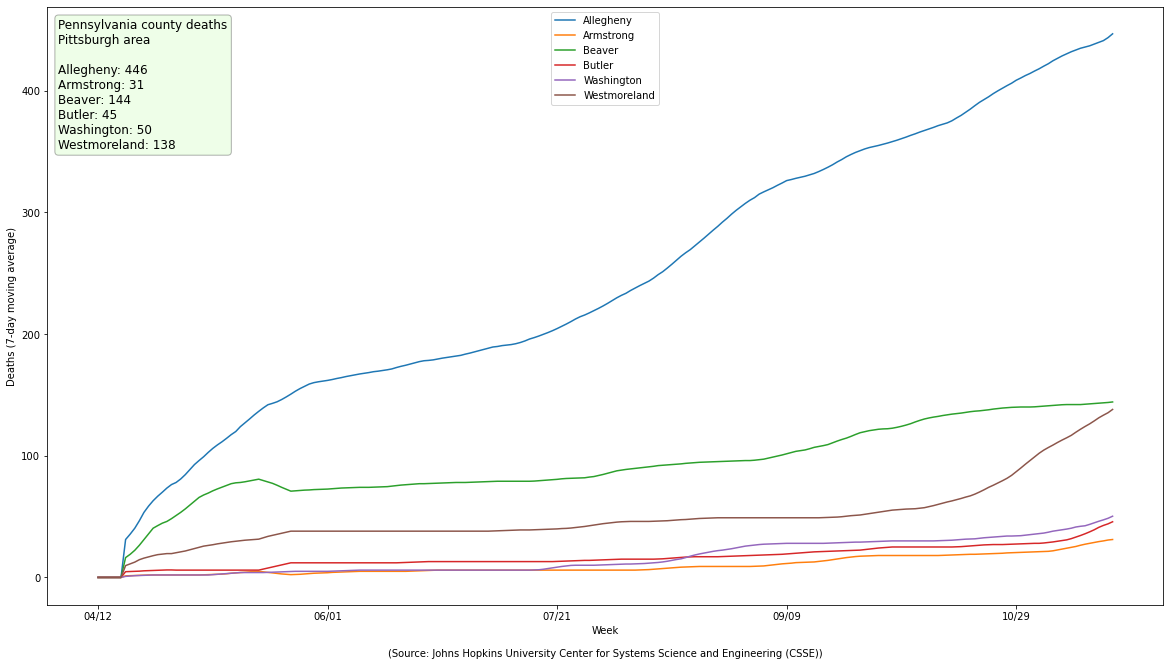

In [69]:
pgh_area_counties = ('Allegheny', 'Butler', 'Beaver',
                     'Washington', 'Westmoreland', 'Armstrong')
plot_counties(df_counties, 'Pennsylvania', pgh_area_counties, source=SOURCE, moving_average=True,
              textbox_heading="Pittsburgh area", metric=MetricType.DEATHS, image_file='jhu-pgh-area-deaths.png')

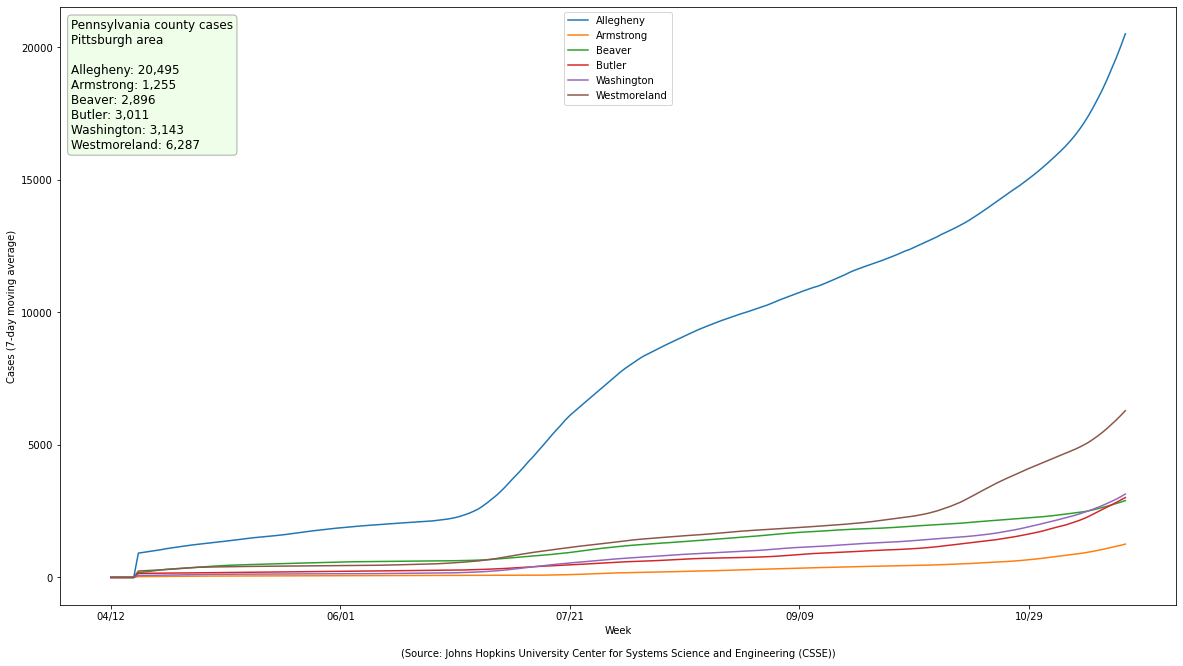

In [70]:
plot_counties(df_counties, 'Pennsylvania', pgh_area_counties, source=SOURCE, moving_average=True,
              textbox_heading="Pittsburgh area", metric=MetricType.CASES, image_file='jhu-pgh-area-cases.png')

#### Some daily stats for certain counties

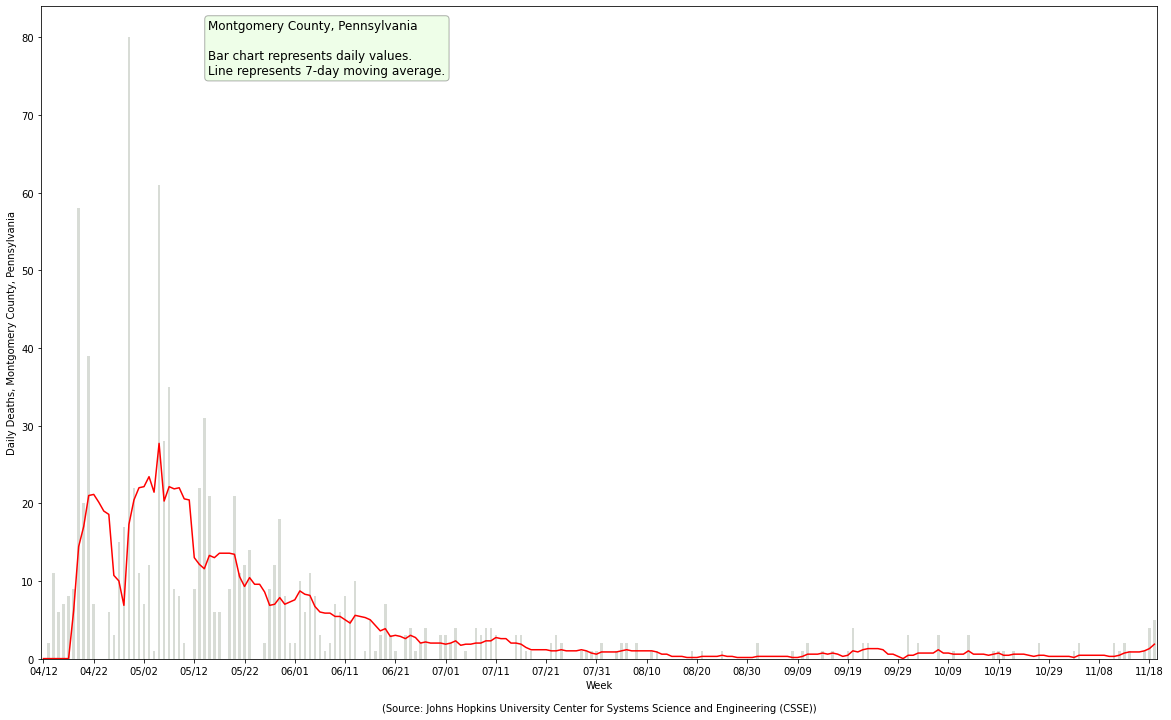

In [71]:
plot_county_daily_stats(df_counties, 'Pennsylvania', 'Montgomery', source=SOURCE, metric=MetricType.DEATHS, 
                        textbox_loc=(0.15, 0.98), image_file='jhu-pa-montgomery-county-daily-deaths.png');

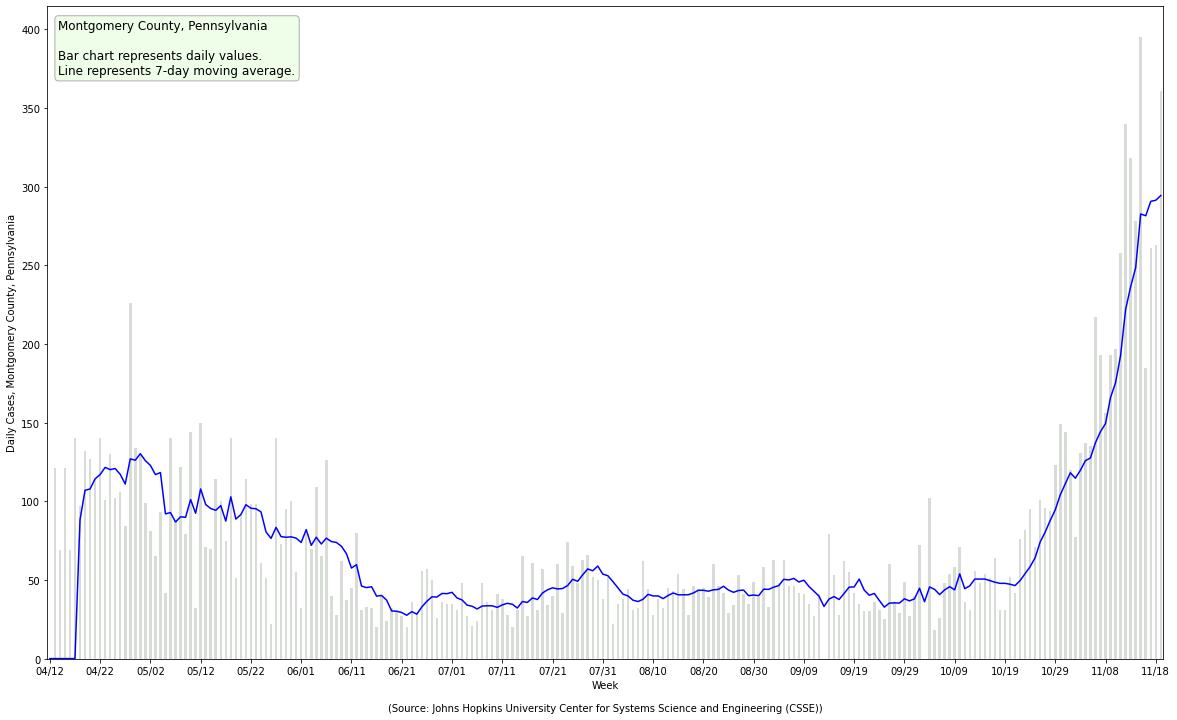

In [72]:
plot_county_daily_stats(df_counties, 'Pennsylvania', 'Montgomery', source=SOURCE, metric=MetricType.CASES, 
                        textbox_loc=None, image_file='jhu-pa-montgomery-county-daily-cases.png');

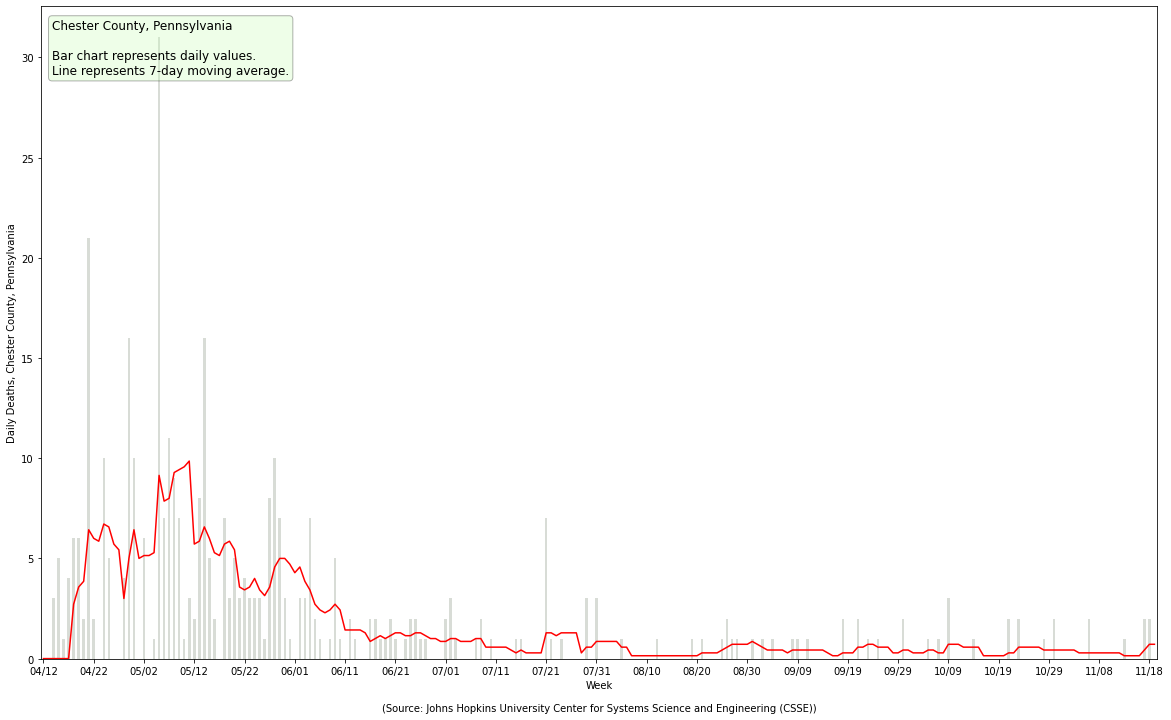

In [73]:
plot_county_daily_stats(df_counties, 'Pennsylvania', 'Chester', source=SOURCE, metric=MetricType.DEATHS, 
                        textbox_loc=None, image_file='jhu-pa-chester-county-daily-deaths.png');

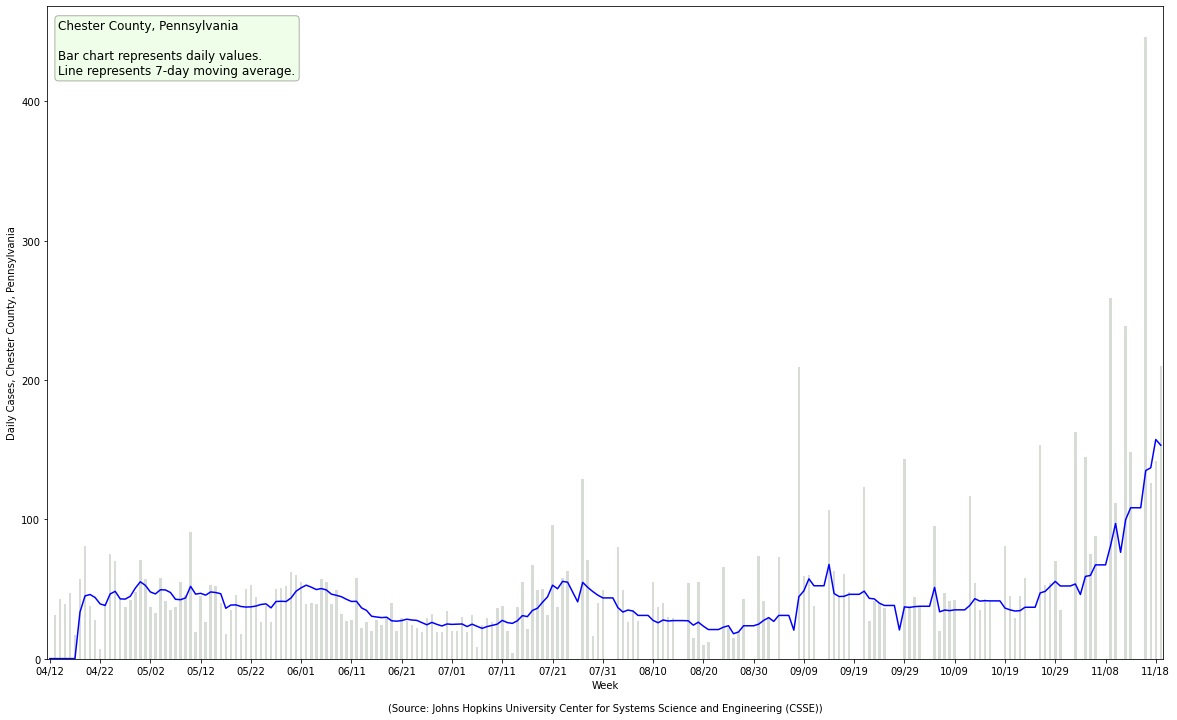

In [74]:
plot_county_daily_stats(df_counties, 'Pennsylvania', 'Chester', source=SOURCE, metric=MetricType.CASES, 
                        textbox_loc=None, image_file='jhu-pa-chester-county-daily-cases.png');

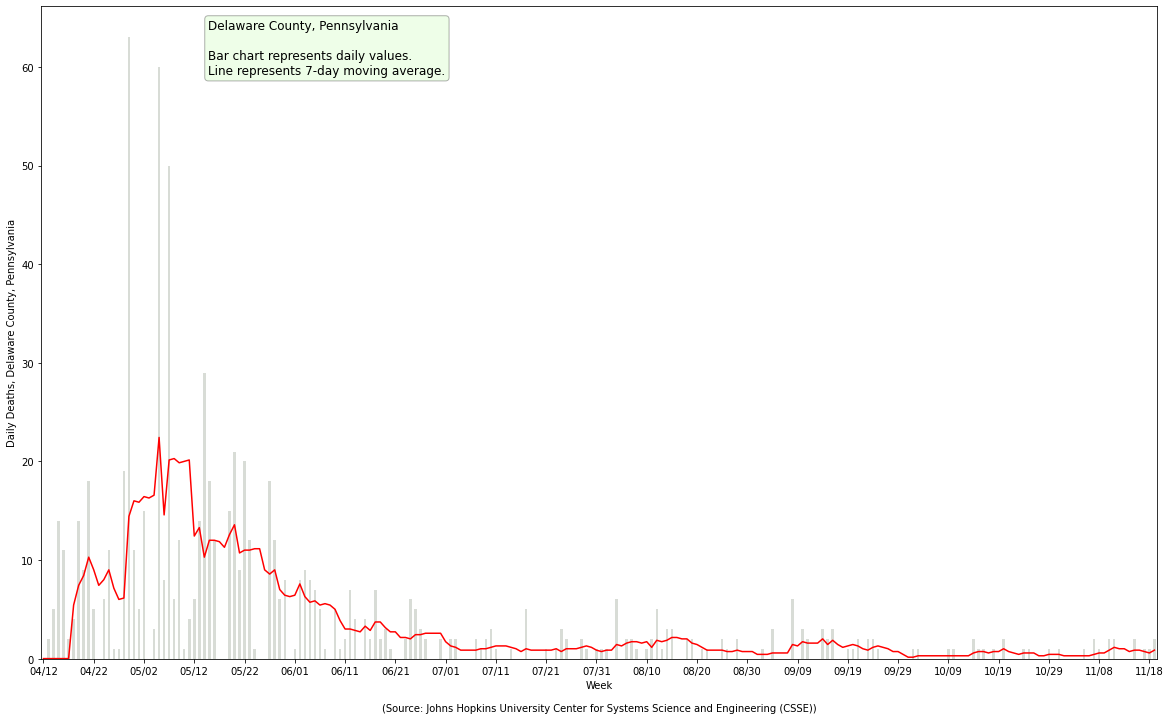

In [75]:
plot_county_daily_stats(df_counties, 'Pennsylvania', 'Delaware', source=SOURCE, metric=MetricType.DEATHS, 
                        textbox_loc=(0.15, 0.98), image_file='jhu-pa-delaware-county-daily-deaths.png');

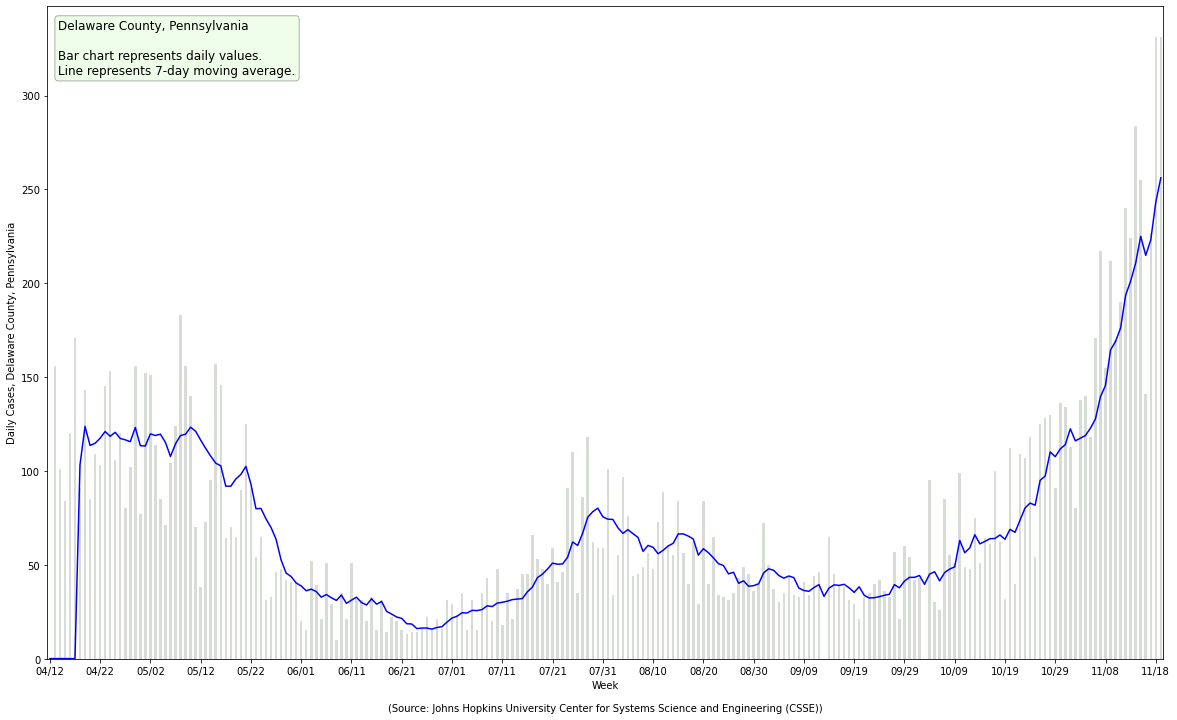

In [76]:
plot_county_daily_stats(df_counties, 'Pennsylvania', 'Delaware', source=SOURCE, metric=MetricType.CASES, 
                        textbox_loc=None, image_file='jhu-pa-delaware-county-daily-cases.png');

(<Figure size 1440x864 with 1 Axes>,
 <AxesSubplot:xlabel='Week\n\n(Source: Johns Hopkins University Center for Systems Science and Engineering (CSSE))', ylabel='Daily Cases, Bucks County, Pennsylvania'>)

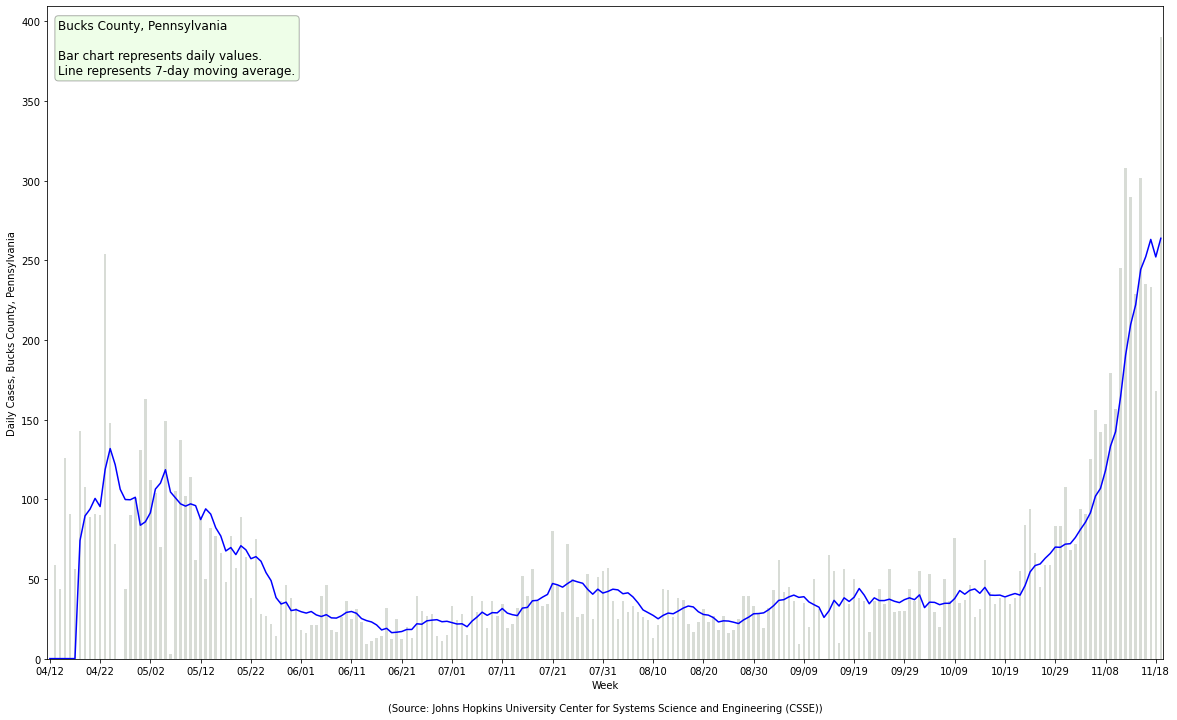

In [77]:
plot_county_daily_stats(df_counties, 'Pennsylvania', 'Bucks', source=SOURCE, metric=MetricType.CASES, 
                        textbox_loc=None, image_file='jhu-pa-bucks-county-daily-cases.png')

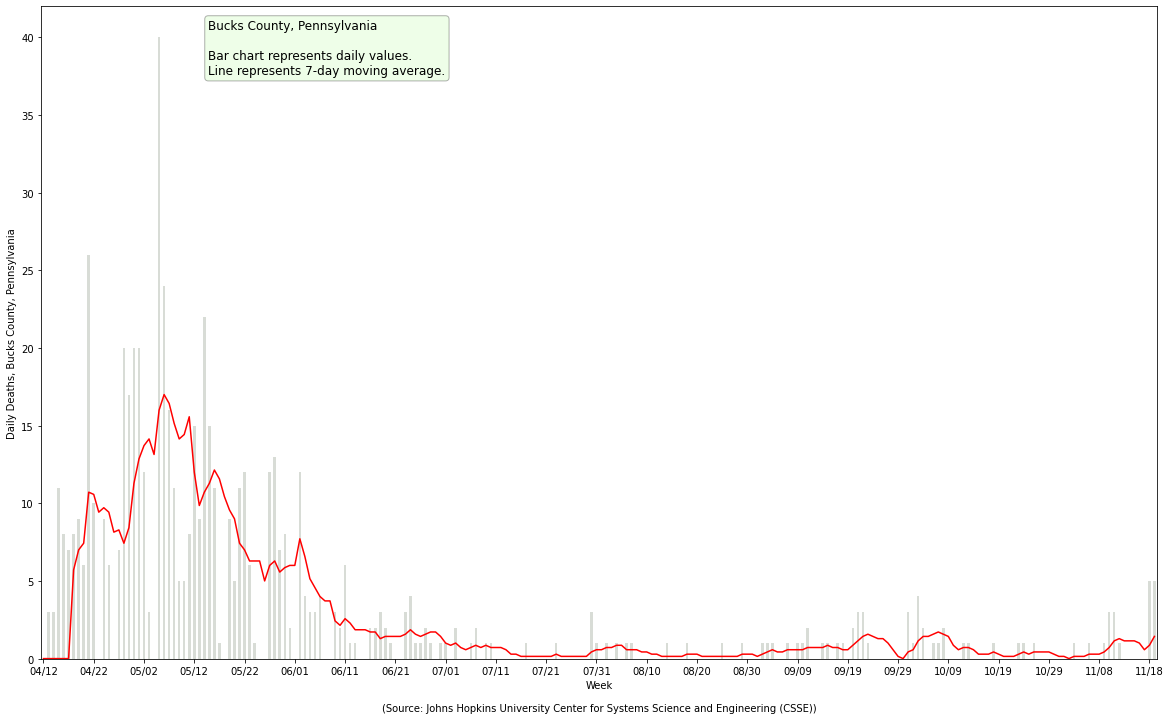

In [78]:
plot_county_daily_stats(df_counties, 'Pennsylvania', 'Bucks', source=SOURCE, metric=MetricType.DEATHS, 
                        textbox_loc=(0.15, 0.98), image_file='jhu-pa-bucks-county-daily-deaths.png');

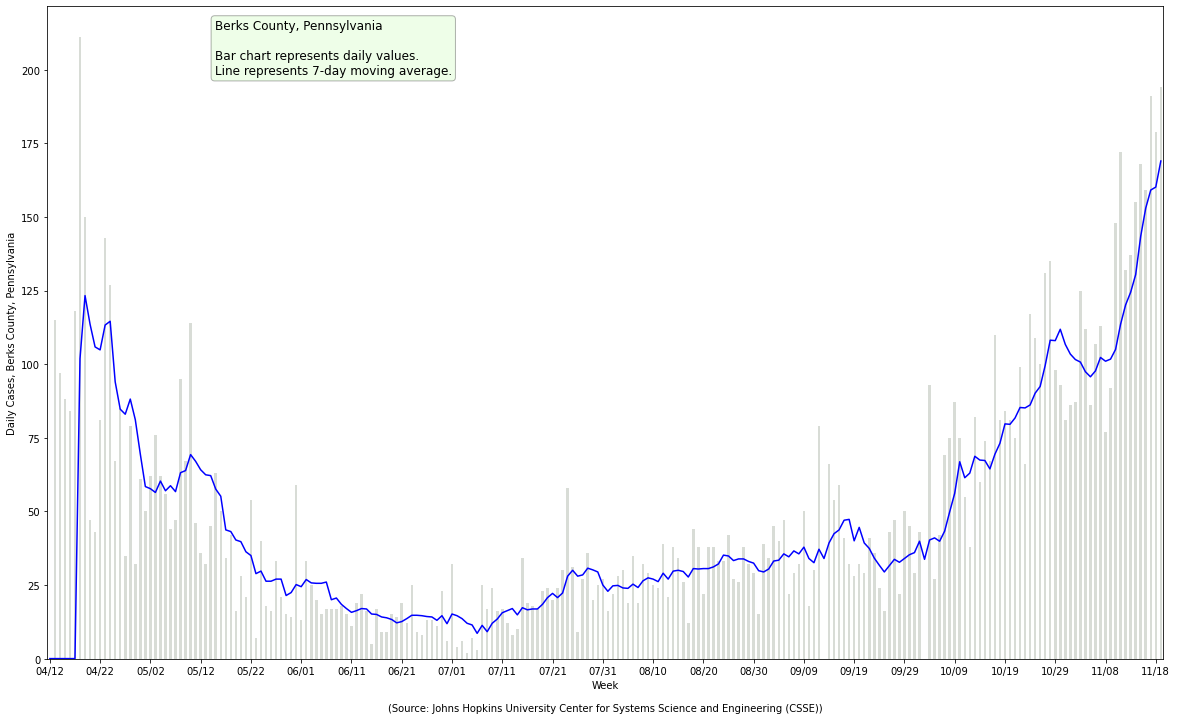

In [79]:
plot_county_daily_stats(df_counties, 'Pennsylvania', 'Berks', source=SOURCE, metric=MetricType.CASES, 
                        textbox_loc=(0.15, 0.98), image_file='jhu-pa-berks-county-daily-cases.png');

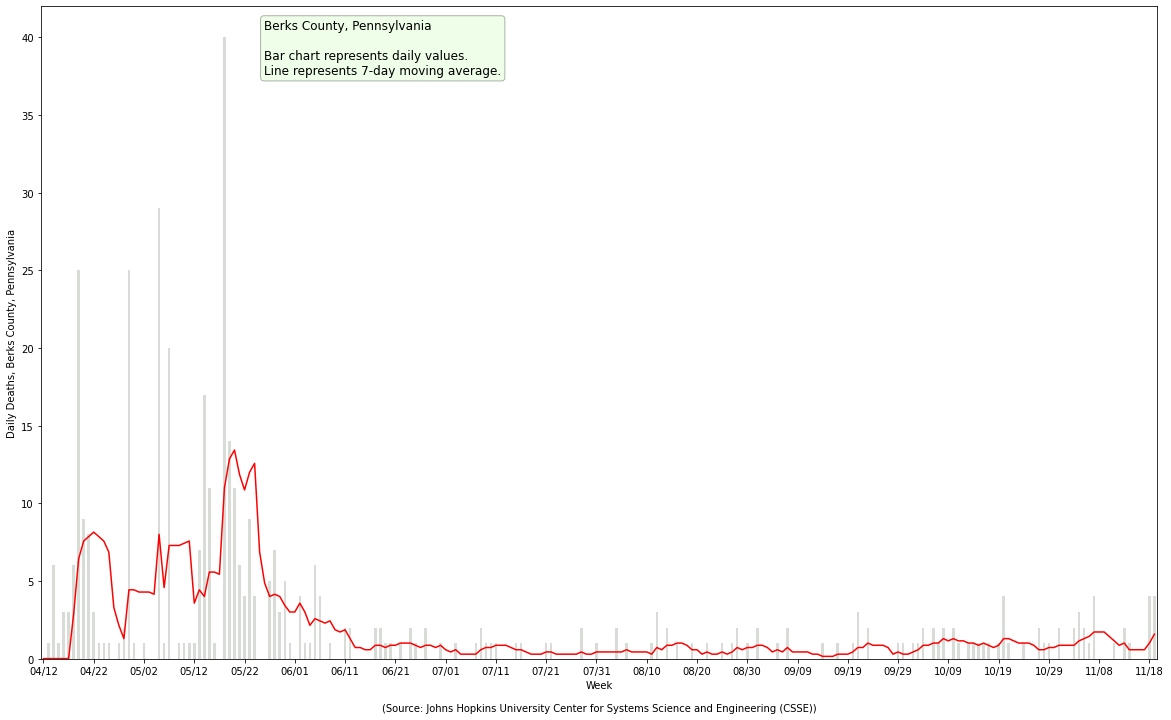

In [80]:
plot_county_daily_stats(df_counties, 'Pennsylvania', 'Berks', source=SOURCE, metric=MetricType.DEATHS, 
                        textbox_loc=(0.20, 0.98), image_file='jhu-pa-berks-county-daily-deaths.png');

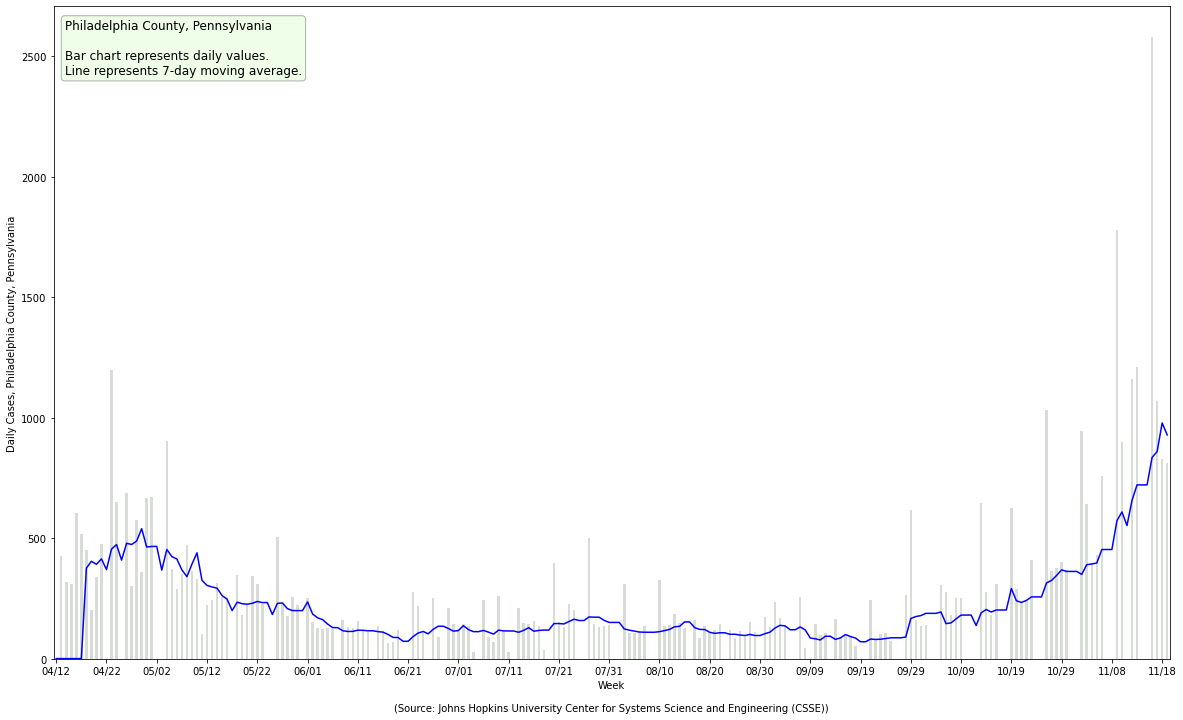

In [81]:
plot_county_daily_stats(df_counties, 'Pennsylvania', 'Philadelphia', source=SOURCE, metric=MetricType.CASES, 
                        textbox_loc=(0.01, 0.98), image_file='jhu-pa-phila-county-daily-cases.png');

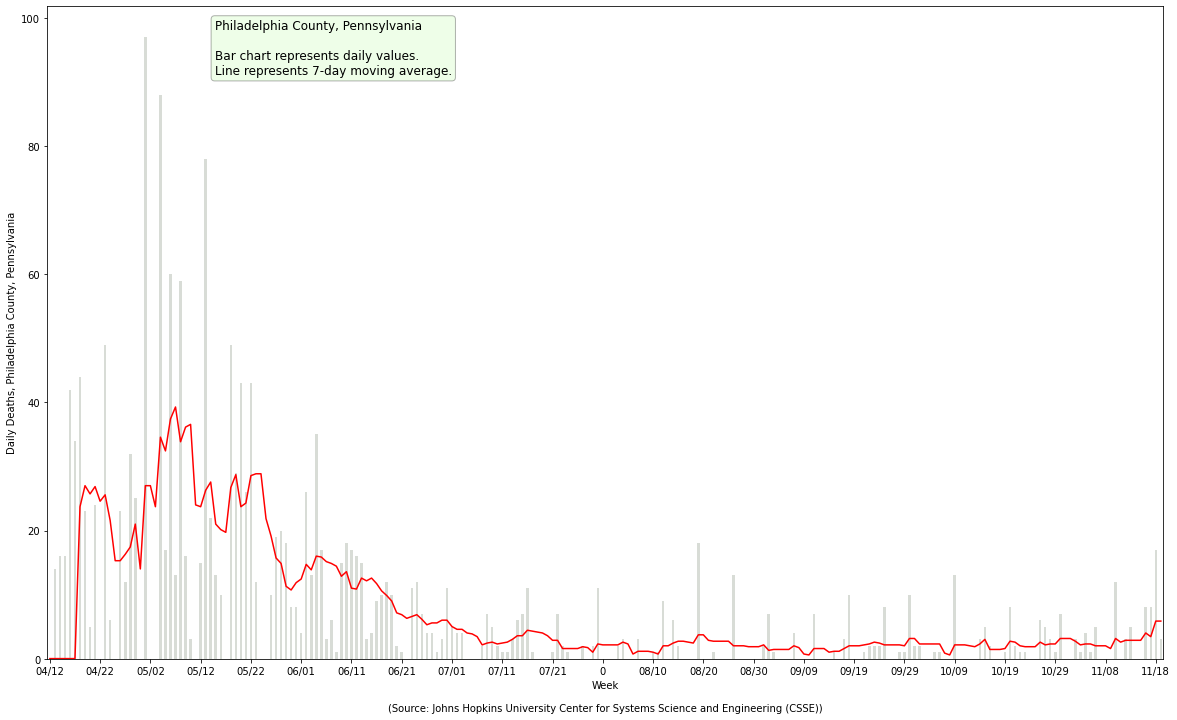

In [82]:
plot_county_daily_stats(df_counties, 'Pennsylvania', 'Philadelphia', source=SOURCE, metric=MetricType.DEATHS, 
                        textbox_loc=(0.15, 0.98), image_file='jhu-pa-phila-county-daily-deaths.png');

### Florida 

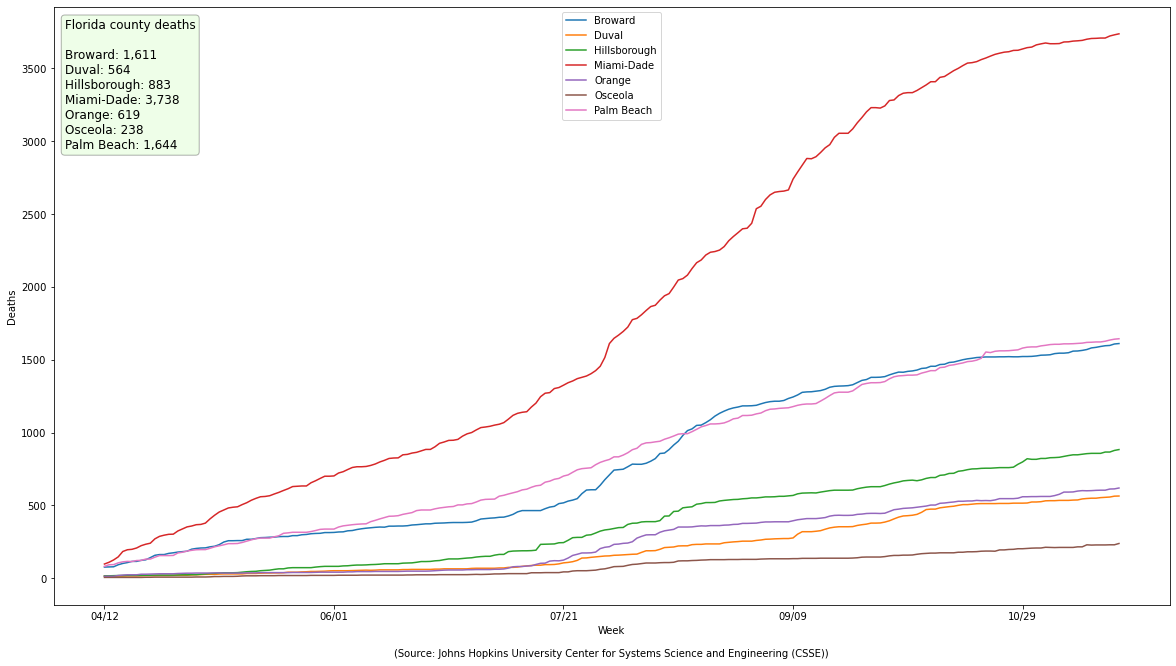

In [83]:
# Osceola and Orange are near Orlando.
# Hillsborough contains Tampa.
# Broward and Palm Beach are near Miami.
# Duval contains Jacksonville.
fl_counties = ('Osceola', 'Orange', 'Miami-Dade', 'Palm Beach',
               'Broward', 'Hillsborough', 'Duval')
plot_counties(df_counties, 'Florida', fl_counties, 
              image_file='jhu-fl-county-deaths.png', source=SOURCE, metric=MetricType.DEATHS)

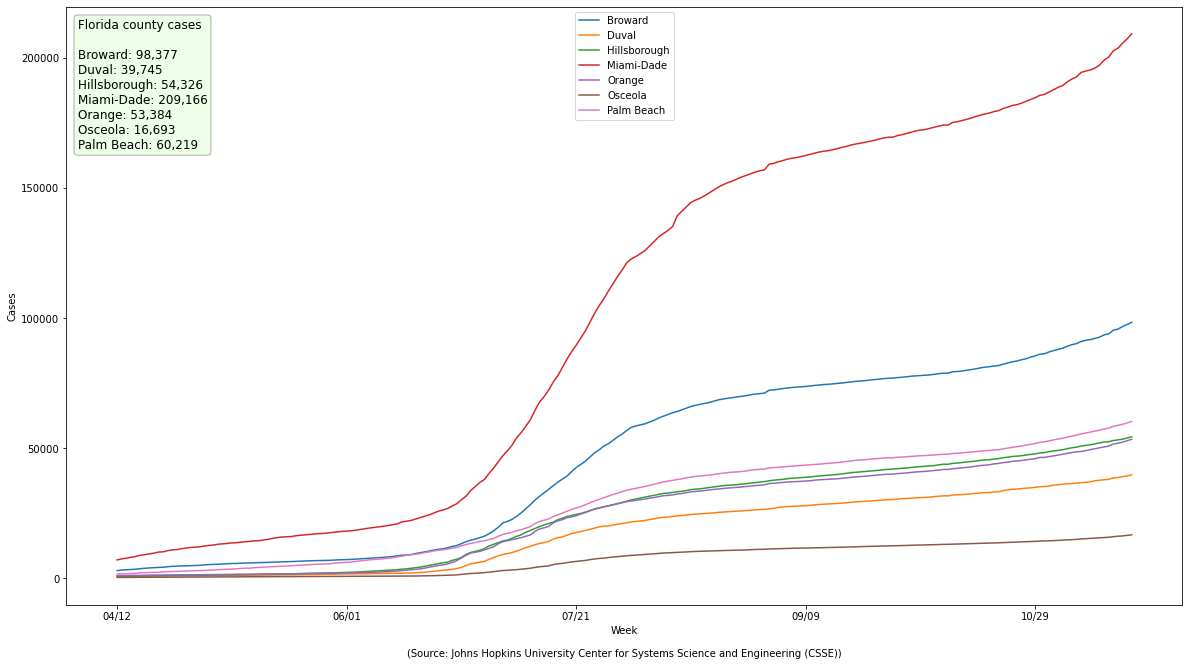

In [84]:
plot_counties(df_counties, 'Florida', fl_counties, 
              image_file='nyt-fl-county-cases.png', source=SOURCE, metric=MetricType.CASES)

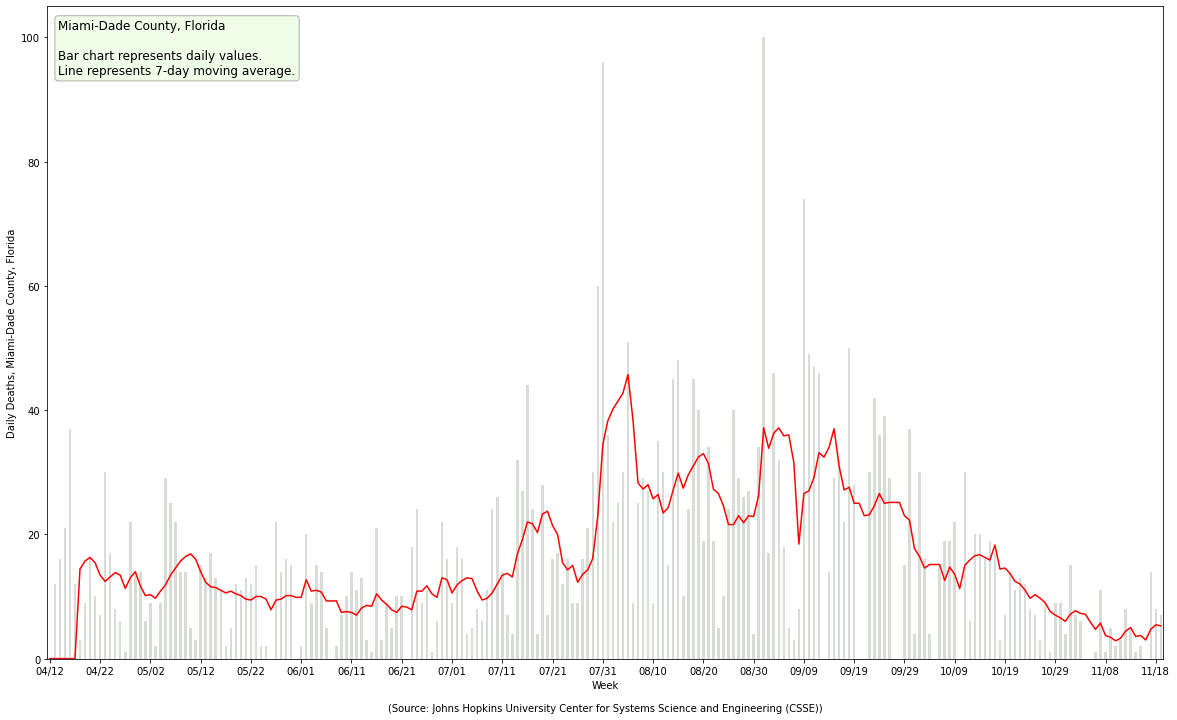

In [85]:
plot_county_daily_stats(df_counties, 'Florida', 'Miami-Dade', source=SOURCE, metric=MetricType.DEATHS, 
                        textbox_loc=None, image_file='jhu-fl-miami-county-daily-deaths.png');

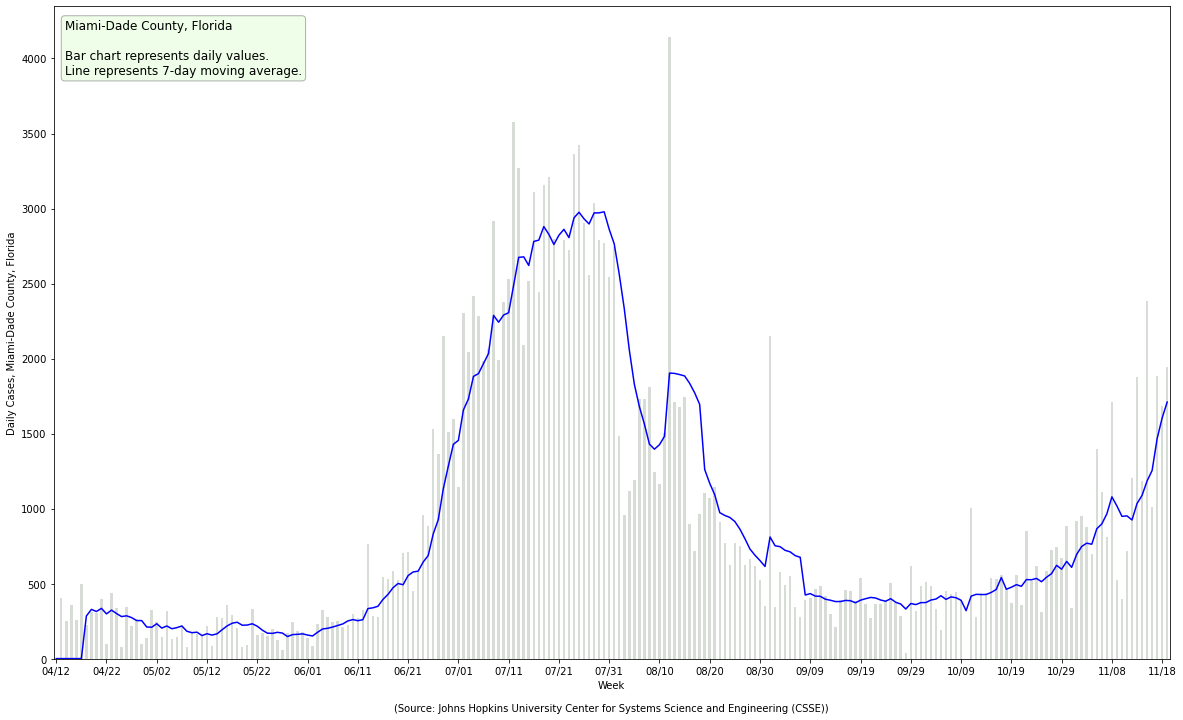

In [86]:
plot_county_daily_stats(df_counties, 'Florida', 'Miami-Dade', source=SOURCE, metric=MetricType.CASES, 
                        textbox_loc=None, image_file='jhu-fl-miami-county-daily-cases.png');

### New York City

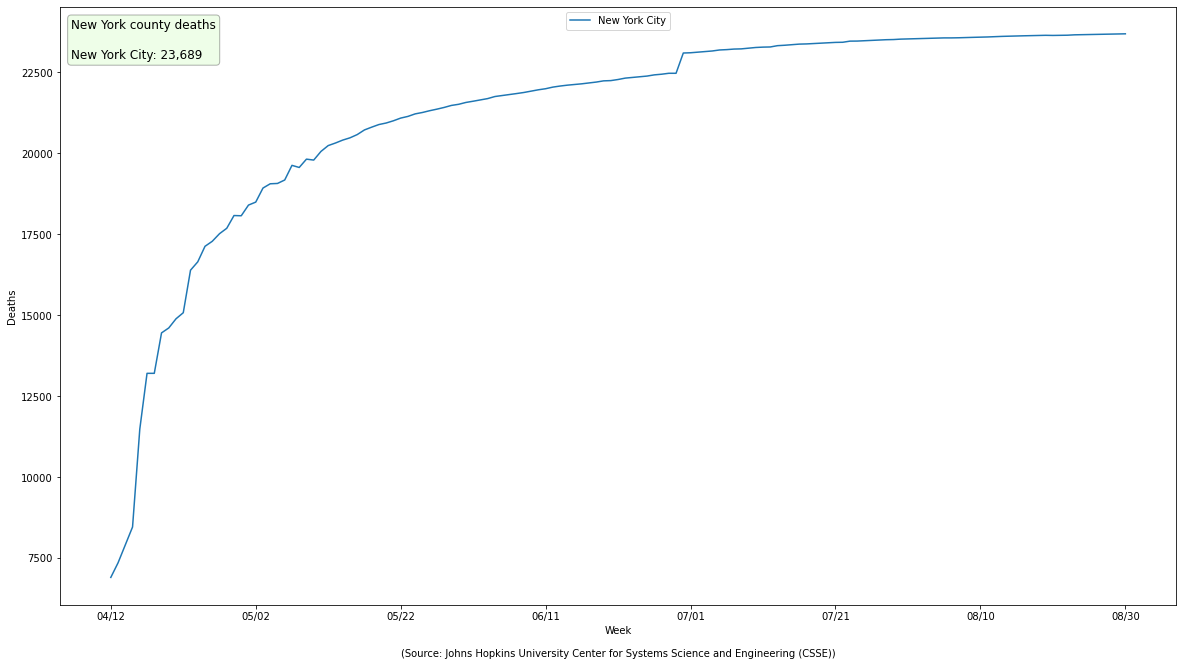

In [87]:
# The NY Times data coalesces the five New York City counties
# into "New York City".
plot_counties(df_counties, 'New York', ['New York City'], source=SOURCE, 
              image_file='jhu-nyc-county-deaths.png', metric=MetricType.DEATHS)

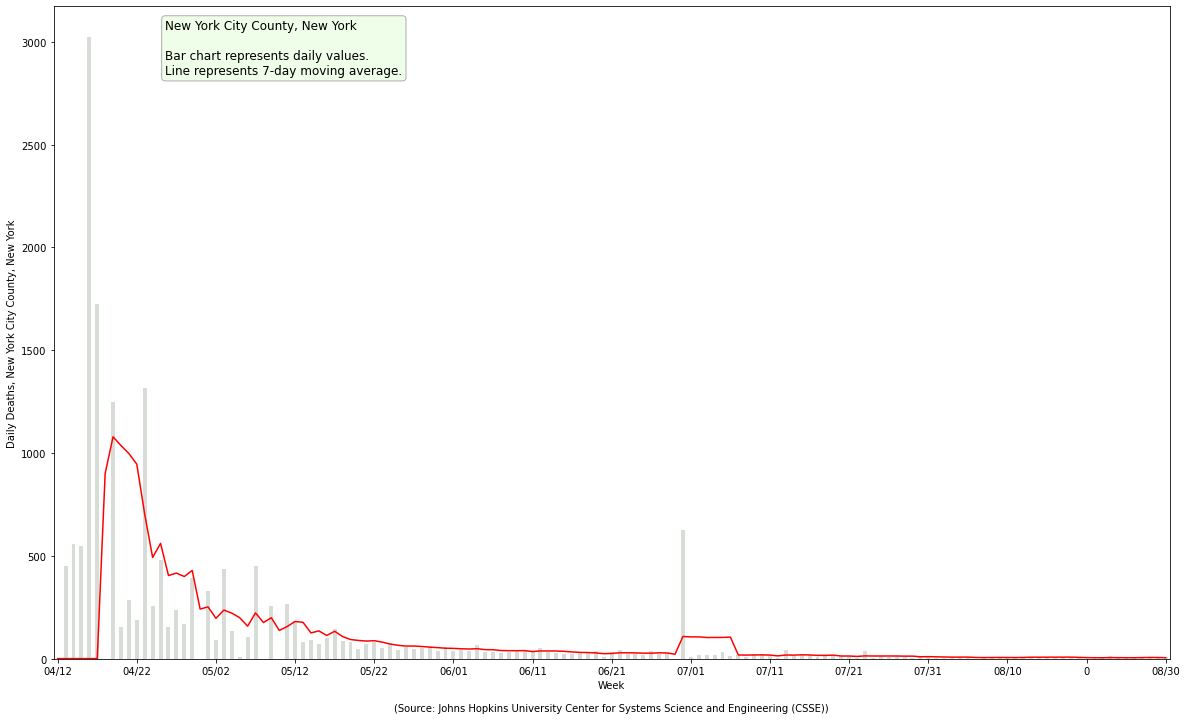

In [88]:
plot_county_daily_stats(df_counties, 'New York', 'New York City', source=SOURCE, metric=MetricType.DEATHS, 
                        textbox_loc=(0.10, 0.98), image_file='jhu-ny-nyc-daily-deaths.png');

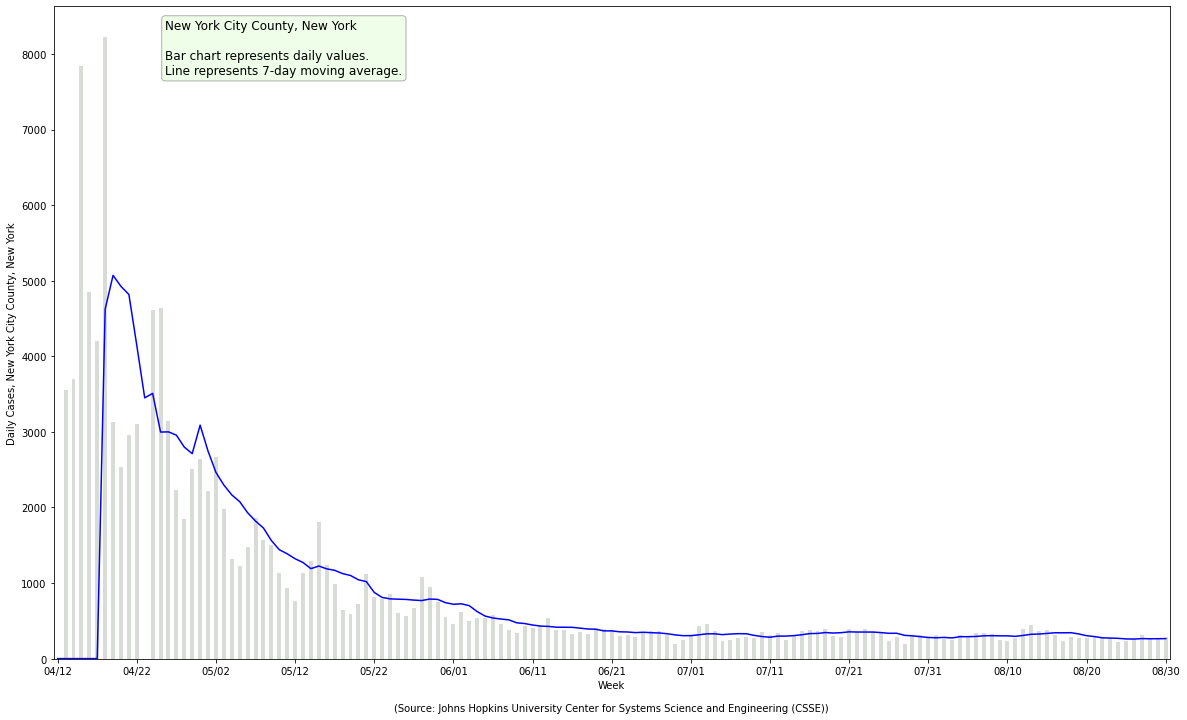

In [89]:
plot_county_daily_stats(df_counties, 'New York', 'New York City', source=SOURCE, metric=MetricType.CASES, 
                        textbox_loc=(0.10, 0.98), image_file='jhu-ny-nyc-daily-cases.png');